In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.neural_network import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

import datetime

import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
DATASET_PATH = 'tree.csv'

In [3]:
df = pd.read_csv(DATASET_PATH)
print(df.shape)
df.head()

(133129, 28)


C:\Users\nguye\AppData\Local\Temp\ipykernel_28492\840374347.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATASET_PATH)


,Editing,Botanical Name,Common Name,DBH,Total Yearly Eco Benefits ($),Stormwater Benefits ($),Stormwater Gallons Saved,Greenhouse CO2 Benefits ($),CO2 Avoided (in lbs.),CO2 Sequestered (in lbs.),Energy Benefits ($),kWh Saved,Therms Saved,Air Quality Benefits ($),Pollutants Saved (in lbs.),Property Benefits ($),Leaf Surface Area (in sq. ft.),Address,Street,Side,Site,Council District,Park Name,Latitude,Longitude,Site ID,Location,location
0,Buffalo,VACANT,VACANT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293,Linden Av,Front,1,Delaware,0,42.944564,-78.853778,58174,"(42.9445636713, -78.8537781977)",POINT (-78.8537781977 42.9445636713)
1,Buffalo,VACANT,VACANT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,344,Woodward Av,Side,1,Delaware,0,42.938299,-78.849355,58666,"(42.9382988357101, -78.8493548021878)",POINT (-78.8493548021878 42.9382988357101)
2,Buffalo,VACANT,VACANT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69,Coburg St,Front,1,Delaware,0,42.957930,-78.844945,61166,"(42.9579302587484, -78.8449448025202)",POINT (-78.8449448025202 42.9579302587484)
3,Buffalo,VACANT,VACANT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2053,Hertel Av,Front,1,Delaware,0,42.946482,-78.832560,66853,"(42.9464824572, -78.8325596768)",POINT (-78.8325596768 42.9464824572)
4,Buffalo,VACANT,VACANT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,214,Wohlers Av,Front,1,Ellicott,0,42.909637,-78.848150,9939,"(42.9096368144715, -78.8481499390883)",POINT (-78.8481499390883 42.9096368144715)


### 2. Provide main statistic about the dataset (e.g. number of entries, features)

In [4]:
df.describe()
# for col in stats: 
#     print(col)
#     print(stats[col])
#     print("missing values ", df[col].isna().sum())

,DBH,Total Yearly Eco Benefits ($),Stormwater Benefits ($),Stormwater Gallons Saved,Greenhouse CO2 Benefits ($),CO2 Avoided (in lbs.),CO2 Sequestered (in lbs.),Energy Benefits ($),kWh Saved,Therms Saved,Air Quality Benefits ($),Pollutants Saved (in lbs.),Property Benefits ($),Leaf Surface Area (in sq. ft.),Address,Site,Latitude,Longitude,Site ID
count,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000
mean,7.340972,58.462052,3.949765,493.718861,0.306872,59.345414,46.657949,26.212343,39.957150,14.640797,2.554630,0.409396,25.438671,42.278796,1252.579896,1.431574,42.908860,-78.846760,66626.856973
std,10.129378,76.928272,7.487878,935.968131,0.647046,118.153217,111.616991,36.331170,58.207199,20.038251,4.922341,0.787041,34.006640,56.518517,29117.263209,4.130489,0.122244,0.218139,38466.055519
min,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-78.911907,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.000000,1.000000,42.890991,-78.871436,33322.000000
50%,2.000000,15.350000,0.240000,30.110000,0.010000,1.170000,0.770000,4.050000,4.430000,2.430000,0.090000,0.010000,8.990000,14.940000,179.000000,1.000000,42.913243,-78.846541,66623.000000
75%,13.000000,103.250000,4.720000,590.130000,0.200000,36.730000,26.580000,49.030000,73.880000,27.520000,2.220000,0.340000,46.970000,78.060000,414.000000,1.000000,42.936068,-78.821591,99915.000000
max,508.000000,469.300000,68.280000,8534.550000,7.600000,941.650000,1844.070000,170.640000,329.780000,88.380000,44.760000,6.370000,241.990000,402.180000,999999.000000,206.000000,42.965551,0.000000,135976.000000


In [5]:
print('Name count ', len(df['Botanical Name'].unique()))
print('Editing ', df["Editing"].unique())
print('Site ', df["Site"].unique())
print('Side ', df["Side"].unique())

Name count  321
Editing  ['Buffalo' 'Olmsted']
Site  [  1   3   4   2  44  29  26  12   7  31  42  41  11  50   8  13   9   6
  35   5  38  20  34  17  15  21  10  16  32  14  25  27  56  59  18  53
  43  48  64  30  22  55  40  39  33  24  69  23  70  62  37  49  63  19
  60  45   0  52  58  46  54  72  28  36  67  47  66  51  68  57  71  61
  73  65 111  99  80 106 110 101  98  93 102  74  92  81  76  97 104  86
 109  88  82 108 100  78  75  94  96  79  89  84 112  87  95  77  83  85
 103 105  90 107  91 122 133 134 129 114 126 119 124 131 128 116 132 113
 125 135 120 115 206 130 127 121 123 117]
Side  ['Front' 'Side' 'In_Lot' 'Median' 'Rear' '0']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133129 entries, 0 to 133128
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Editing                         133129 non-null  object 
 1   Botanical Name                  133129 non-null  object 
 2   Common Name                     133129 non-null  object 
 3   DBH                             133129 non-null  float64
 4   Total Yearly Eco Benefits ($)   133129 non-null  float64
 5   Stormwater Benefits ($)         133129 non-null  float64
 6   Stormwater Gallons Saved        133129 non-null  float64
 7   Greenhouse CO2 Benefits ($)     133129 non-null  float64
 8   CO2 Avoided (in lbs.)           133129 non-null  float64
 9   CO2 Sequestered (in lbs.)       133129 non-null  float64
 10  Energy Benefits ($)             133129 non-null  float64
 11  kWh Saved                       133129 non-null  float64
 12  Therms Saved    

In [7]:
df.isna().sum()

Editing                           0
Botanical Name                    0
Common Name                       0
DBH                               0
Total Yearly Eco Benefits ($)     0
Stormwater Benefits ($)           0
Stormwater Gallons Saved          0
Greenhouse CO2 Benefits ($)       0
CO2 Avoided (in lbs.)             0
CO2 Sequestered (in lbs.)         0
Energy Benefits ($)               0
kWh Saved                         0
Therms Saved                      0
Air Quality Benefits ($)          0
Pollutants Saved (in lbs.)        0
Property Benefits ($)             0
Leaf Surface Area (in sq. ft.)    0
Address                           0
Street                            0
Side                              0
Site                              0
Council District                  0
Park Name                         0
Latitude                          0
Longitude                         0
Site ID                           0
Location                          1
location                    

In [8]:
print(df.columns)

Index(['Editing', 'Botanical Name', 'Common Name', 'DBH',
       'Total Yearly Eco Benefits ($)', 'Stormwater Benefits ($)',
       'Stormwater Gallons Saved', 'Greenhouse CO2 Benefits ($)',
       'CO2 Avoided (in lbs.)', 'CO2 Sequestered (in lbs.)',
       'Energy Benefits ($)', 'kWh Saved', 'Therms Saved',
       'Air Quality Benefits ($)', 'Pollutants Saved (in lbs.)',
       'Property Benefits ($)', 'Leaf Surface Area (in sq. ft.)', 'Address',
       'Street', 'Side', 'Site', 'Council District', 'Park Name', 'Latitude',
       'Longitude', 'Site ID', 'Location', 'location'],
      dtype='object')


### 6. Provide at least 5 visualization graphs with a brief description for each graph, e.g. discuss if there are any interesting patterns or correlations. 

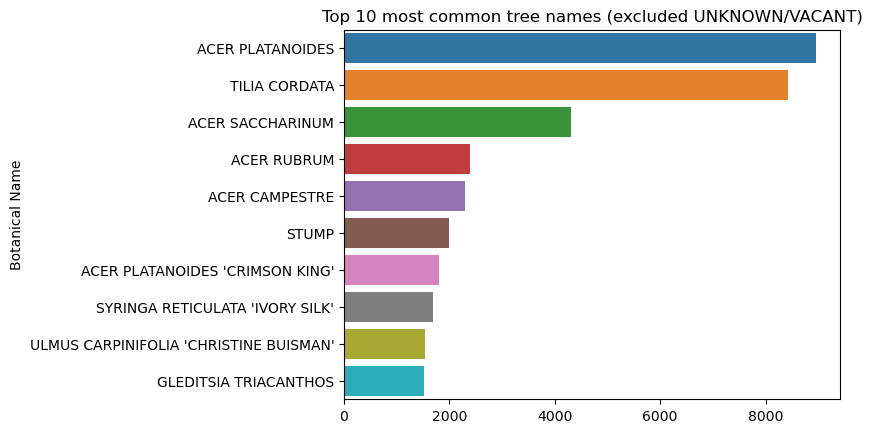

In [9]:
a = df['Botanical Name'].value_counts()[1:11]
sns.barplot(x = a.values, y = a.index, orient = 'h')
plt.title('Top 10 most common tree names (excluded UNKNOWN/VACANT)')
plt.show()

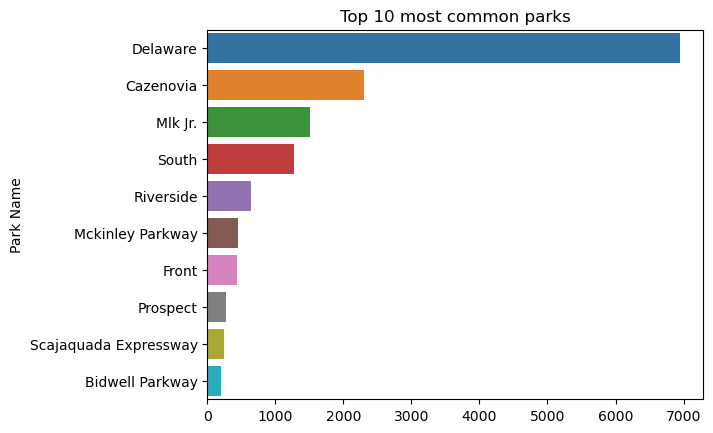

In [10]:
col = 'Park Name'
#Excluded 2 values of 0s, 1 type of string, 1 type of int
a = df[col].value_counts()[2:12]
sns.barplot(x = a.values, y = a.index, orient = 'h')
plt.title('Top 10 most common parks')
plt.show()

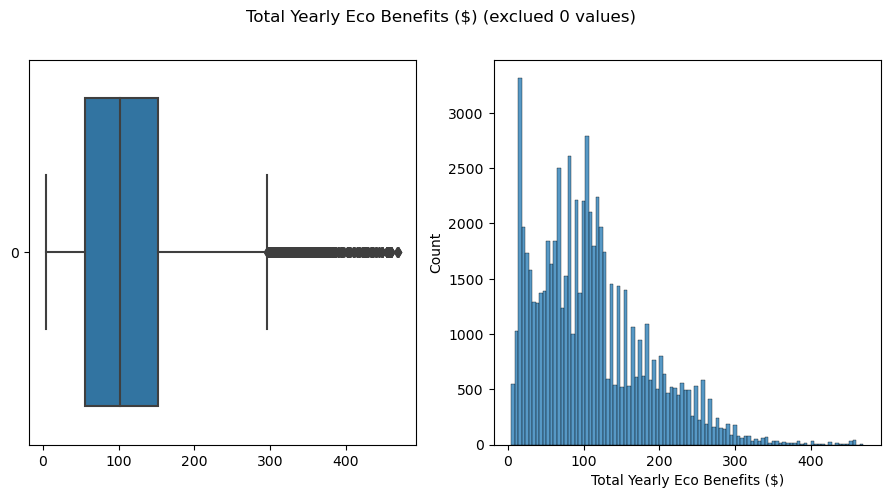

In [11]:
col = 'Total Yearly Eco Benefits ($)'
a = df[df[col] > 0][col]
a = a.reset_index(drop = True)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,5))
sns.boxplot(a, orient='h', ax = ax1)
sns.histplot(a, ax = ax2)
fig.suptitle(col + ' (exclued 0 values)')
plt.show()

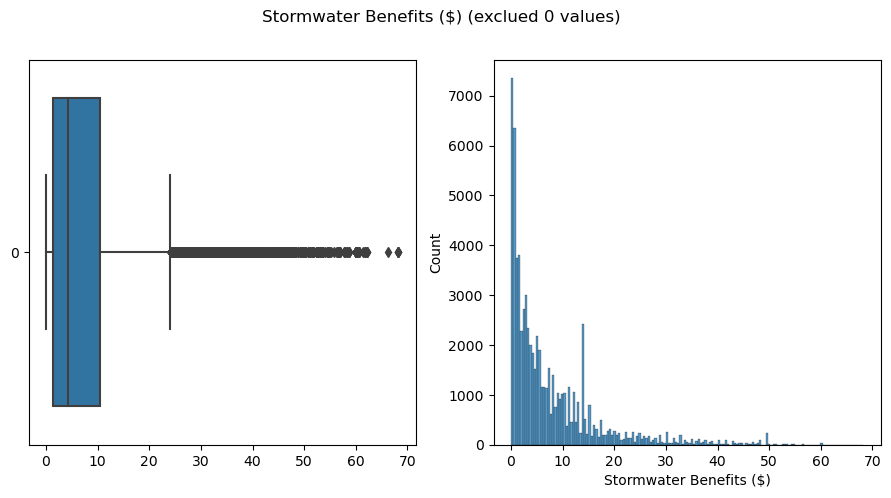

In [12]:
col = 'Stormwater Benefits ($)'
a = df[df[col] > 0][col]
a = a.reset_index(drop = True)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,5))
sns.boxplot(a, orient='h', ax = ax1)
sns.histplot(a, ax = ax2)
fig.suptitle(col + ' (exclued 0 values)')
plt.show()

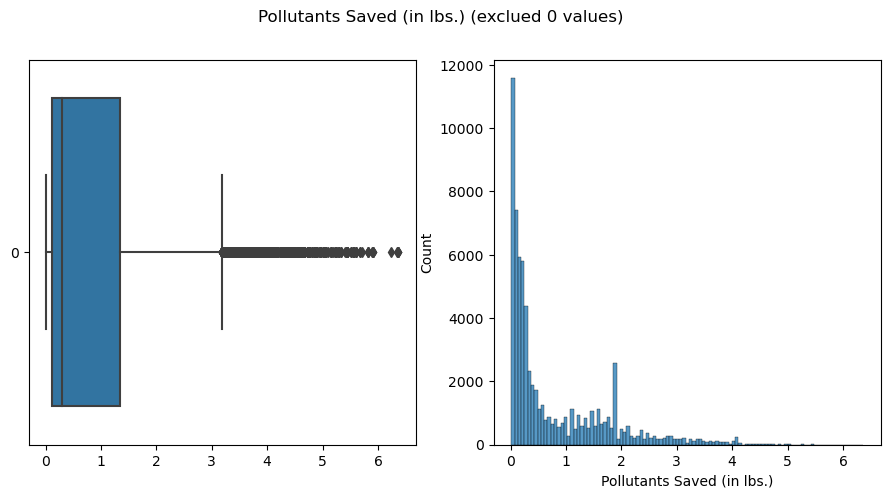

In [13]:
col = 'Pollutants Saved (in lbs.)'
a = df[df[col] > 0][col]
a = a.reset_index(drop = True)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,5))
sns.boxplot(a, orient='h', ax = ax1)
sns.histplot(a, ax = ax2)
fig.suptitle(col + ' (exclued 0 values)')
plt.show()

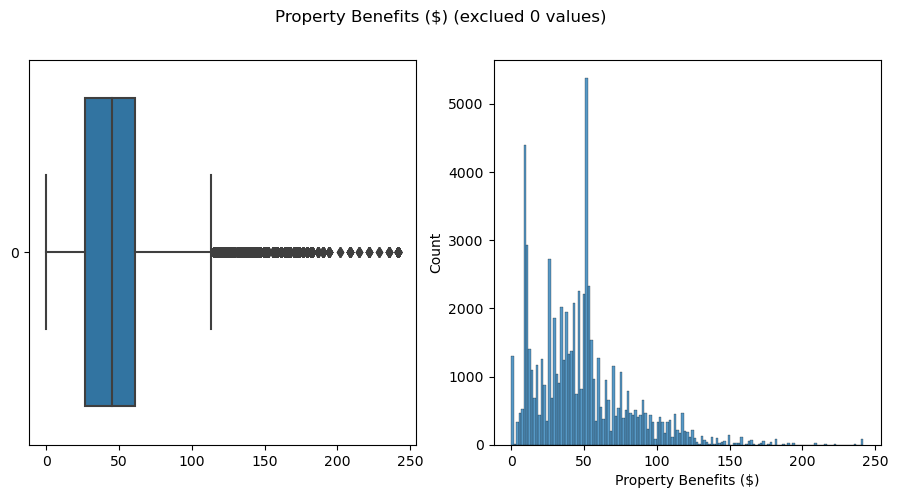

In [14]:
col = 'Property Benefits ($)'
a = df[df[col] > 0][col]
a = a.reset_index(drop = True)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,5))
sns.boxplot(a, orient='h', ax = ax1)
sns.histplot(a, ax = ax2)
fig.suptitle(col + ' (exclued 0 values)')
plt.show()

In [15]:
train_df = df[['Editing', 'Botanical Name', 'Common Name', 'DBH',\
       'Total Yearly Eco Benefits ($)', 'Stormwater Benefits ($)',\
       'Stormwater Gallons Saved', 'Greenhouse CO2 Benefits ($)',\
       'CO2 Avoided (in lbs.)', 'CO2 Sequestered (in lbs.)',\
       'Energy Benefits ($)', 'kWh Saved', 'Therms Saved',\
       'Air Quality Benefits ($)', 'Pollutants Saved (in lbs.)',\
       'Property Benefits ($)', 'Leaf Surface Area (in sq. ft.)', 'Address',\
       'Street', 'Side', 'Site', 'Council District', 'Park Name', 'Latitude',\
       'Longitude']]


### 4.Handle mismatched string formats, if any.
In Park Name column, there are rows that contains 0s in string type, and others contain 0s in int type. They're the same thing so we'll convert them into "None"

In [16]:
train_df['Park Name'] = train_df['Park Name'].replace('0', "None")
train_df['Park Name'] = train_df['Park Name'].replace(0, "None")

C:\Users\nguye\AppData\Local\Temp\ipykernel_28492\2954531389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Park Name'] = train_df['Park Name'].replace('0', "None")
C:\Users\nguye\AppData\Local\Temp\ipykernel_28492\2954531389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Park Name'] = train_df['Park Name'].replace(0, "None")


In [17]:
print(train_df['Park Name'].unique())

['None' 'Prospect' 'Cazenovia' 'South' 'Delaware' 'Lincoln Parkway'
 'Chapin Parkway' 'Colonial Circle' 'Scajaquada Expressway'
 'Bidwell Parkway' 'Mlk Jr.' 'Front' 'Mckinley Parkway' 'Mcclellan Circle'
 'Days' "Soldier'S Circle" 'Riverside' 'Kensington Expressway' 'Heacock'
 'Ferry Circle' 'Gates Circle' 'Symphony Circle' 'Red Jacket Parkway']


### 5. Handle outliers, if any. Detect and manage outliers within the dataset.
There are many outliers in float columns but I'll keep them since they'll may strongly correlate to some trees in the city. 

Note: Will try dropping outliers to improve model performance

### 7. Identify uncorrelated or unrelated features.

### 8. Convert features with string datatype to categorical.

In [18]:
numeric_cols = set(train_df._get_numeric_data().columns)
all_cols = set(train_df.columns)
cat_cols = all_cols - numeric_cols

print(cat_cols)

for col in cat_cols:
    print('transforming column ', col)
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])

{'Council District', 'Editing', 'Botanical Name', 'Common Name', 'Street', 'Park Name', 'Side'}
transforming column  Council District
transforming column  Editing
transforming column  Botanical Name
transforming column  Common Name
transforming column  Street
transforming column  Park Name
transforming column  Side


C:\Users\nguye\AppData\Local\Temp\ipykernel_28492\3146350867.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = le.fit_transform(train_df[col])
C:\Users\nguye\AppData\Local\Temp\ipykernel_28492\3146350867.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = le.fit_transform(train_df[col])
C:\Users\nguye\AppData\Local\Temp\ipykernel_28492\3146350867.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

<Axes: >

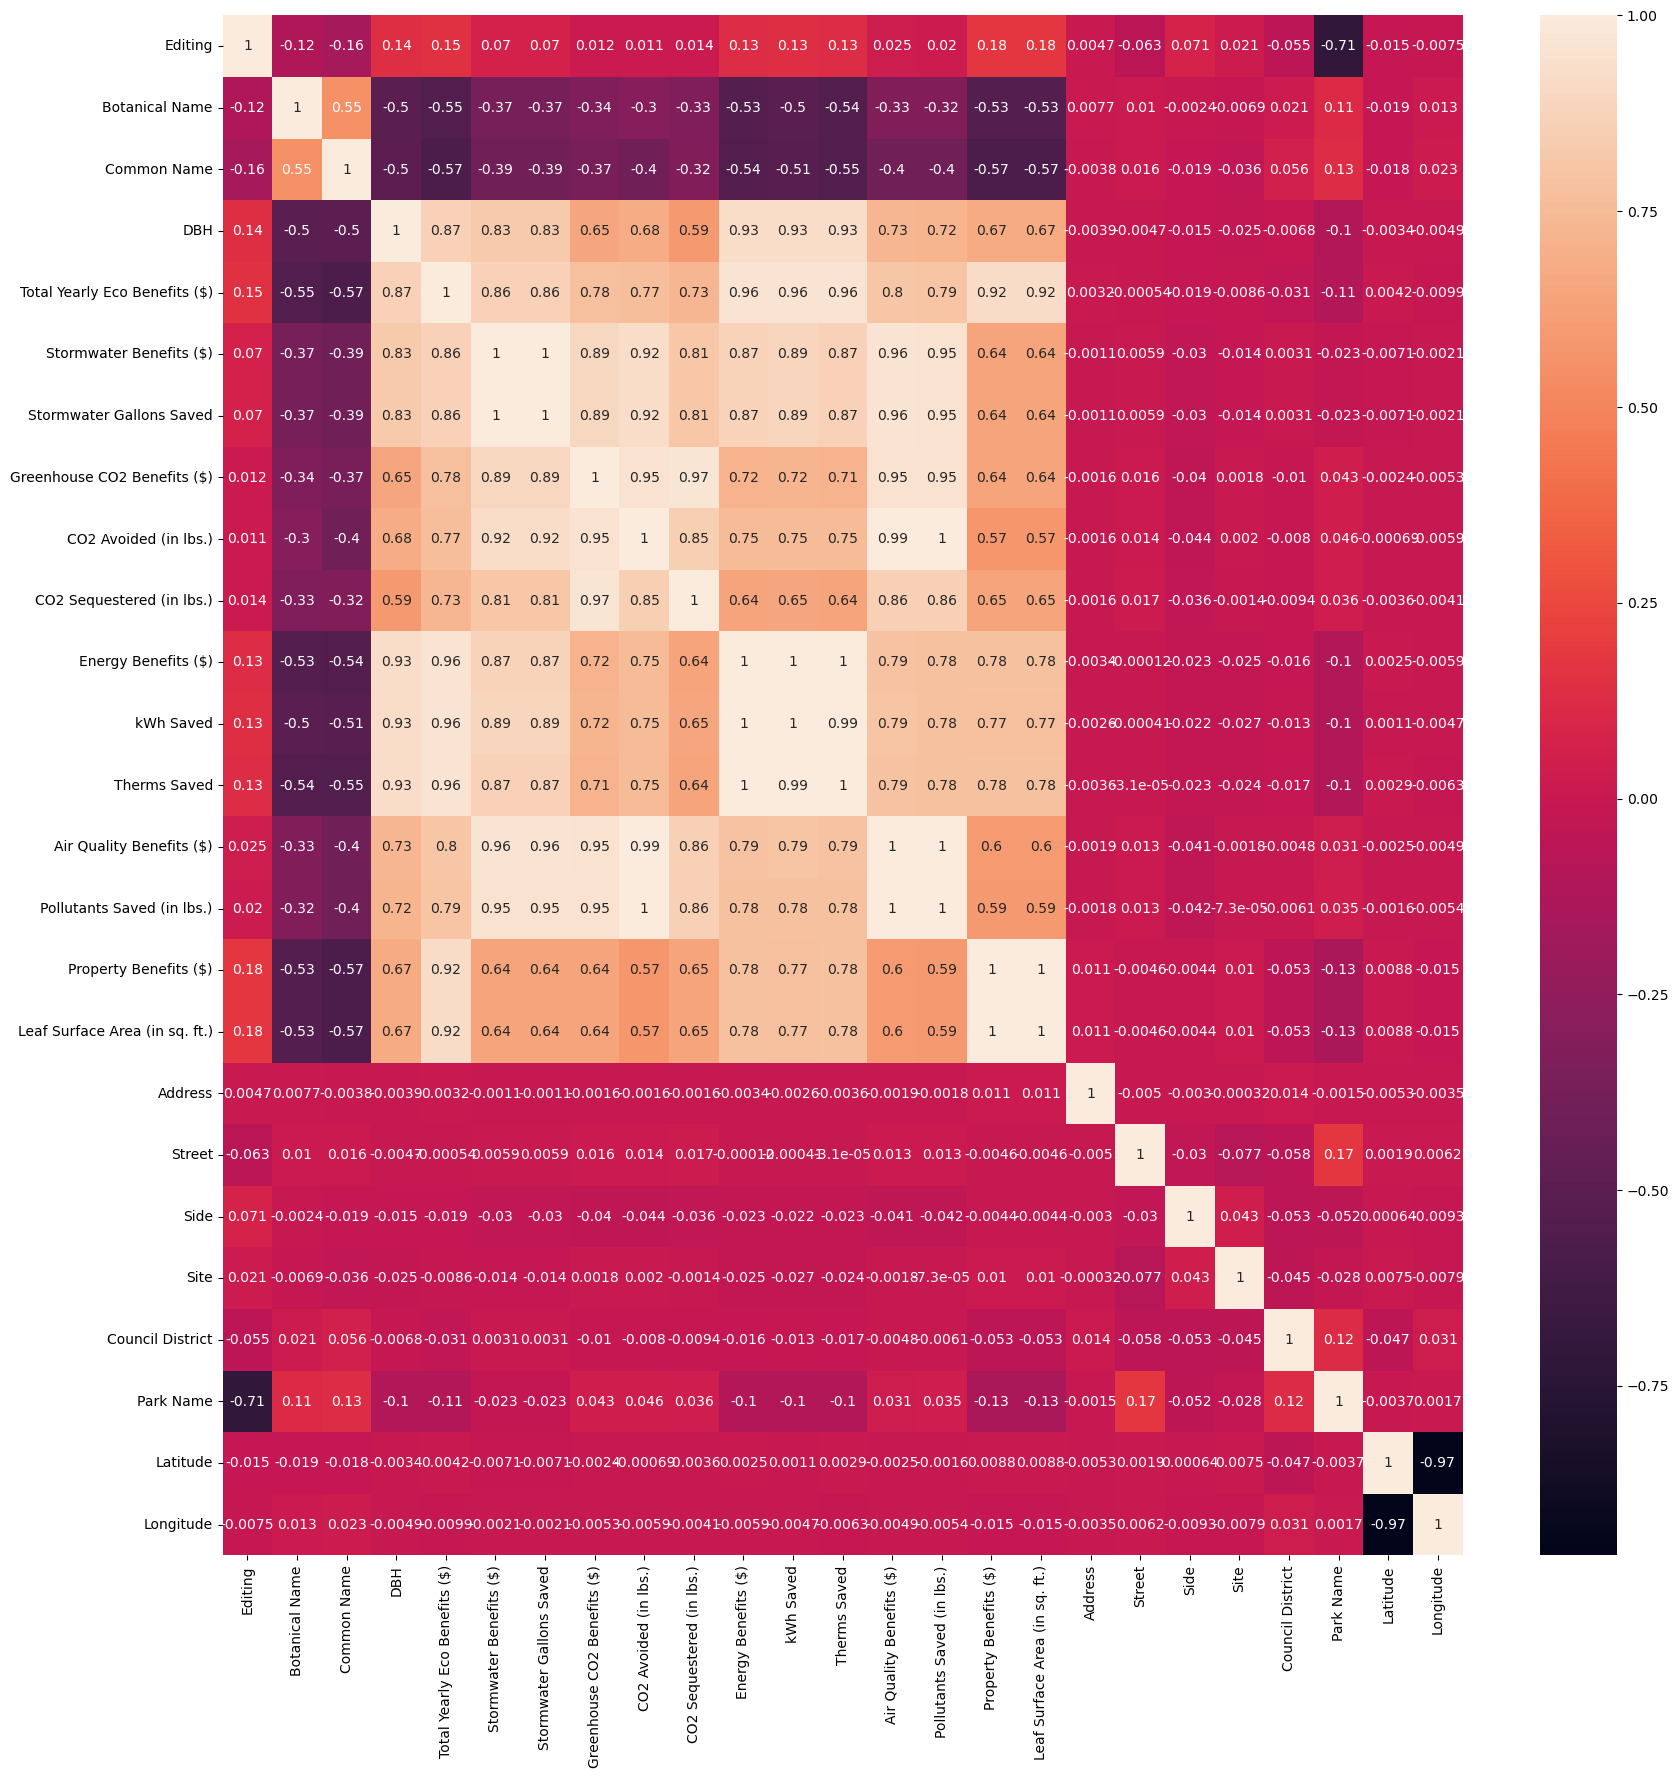

In [19]:
corr_mat = train_df.corr()
fig = plt.figure(figsize = (20,20))
sns.heatmap(corr_mat, annot = True)

<Axes: >

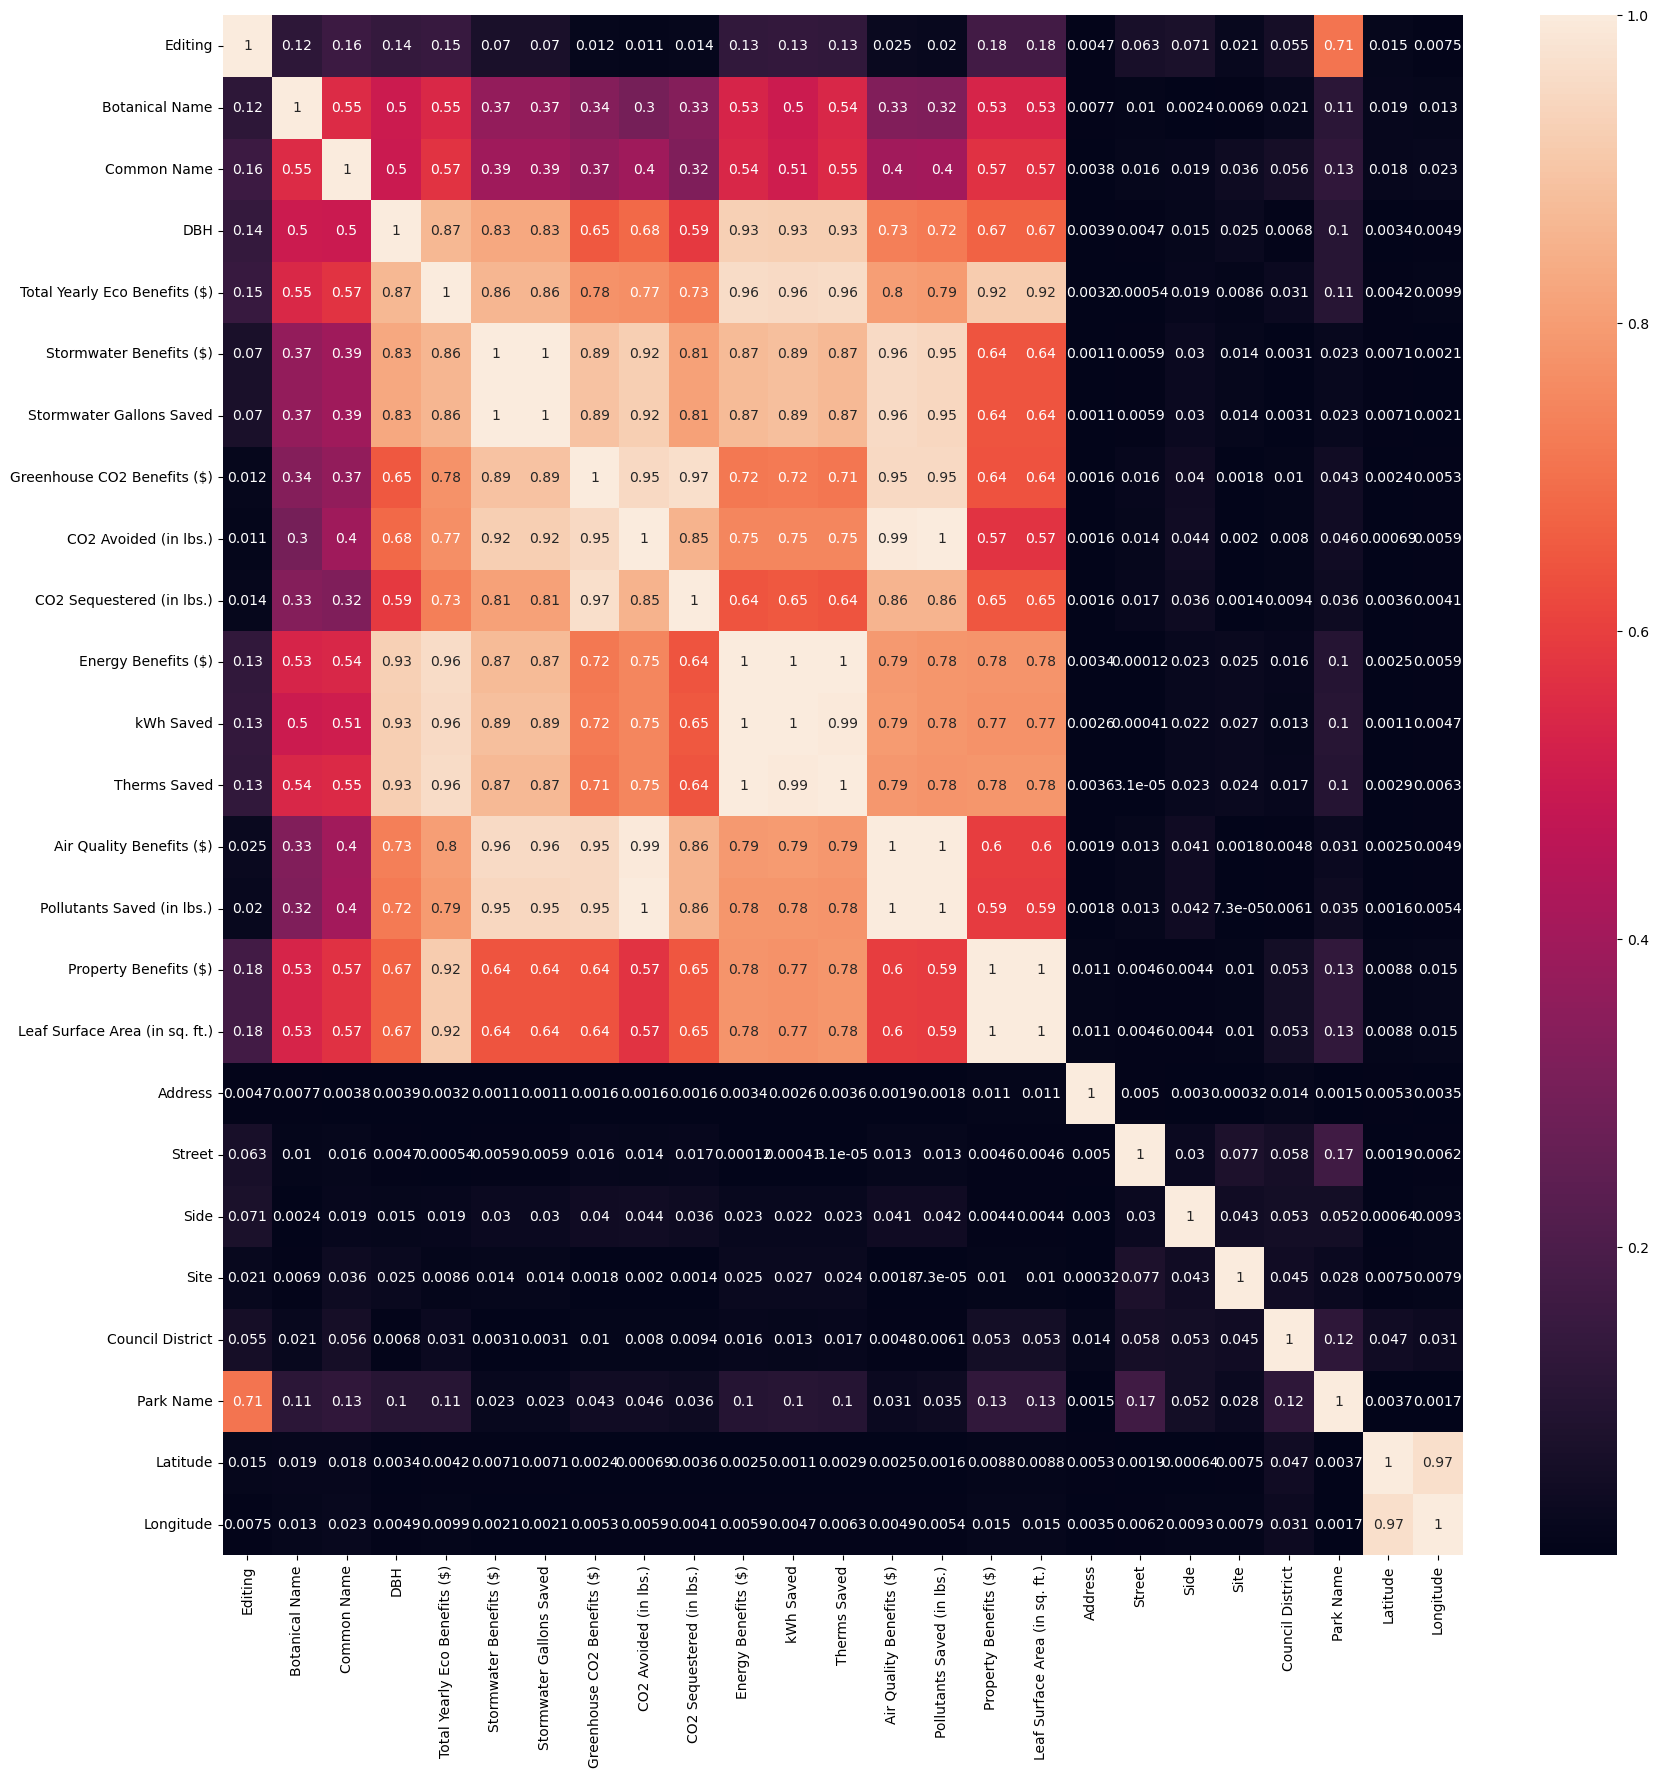

In [20]:
corr_mat = train_df.corr()
fig = plt.figure(figsize = (20,20))
sns.heatmap(np.abs(corr_mat), annot = True)

In [21]:
train_df.describe()

,Editing,Botanical Name,Common Name,DBH,Total Yearly Eco Benefits ($),Stormwater Benefits ($),Stormwater Gallons Saved,Greenhouse CO2 Benefits ($),CO2 Avoided (in lbs.),CO2 Sequestered (in lbs.),Energy Benefits ($),kWh Saved,Therms Saved,Air Quality Benefits ($),Pollutants Saved (in lbs.),Property Benefits ($),Leaf Surface Area (in sq. ft.),Address,Street,Side,Site,Council District,Park Name,Latitude,Longitude
count,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000,133129.000000
mean,0.116406,219.980402,226.318398,7.340972,58.462052,3.949765,493.718861,0.306872,59.345414,46.657949,26.212343,39.957150,14.640797,2.554630,0.409396,25.438671,42.278796,1252.579896,713.632424,1.727182,1.431574,3.667338,14.206807,42.908860,-78.846760
std,0.320712,116.765302,77.085915,10.129378,76.928272,7.487878,935.968131,0.647046,118.153217,111.616991,36.331170,58.207199,20.038251,4.922341,0.787041,34.006640,56.518517,29117.263209,406.520305,1.371264,4.130489,2.654405,3.084692,0.122244,0.218139
min,0.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-78.911907
25%,0.000000,116.000000,165.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.000000,336.000000,1.000000,1.000000,1.000000,15.000000,42.890991,-78.871436
50%,0.000000,285.000000,267.000000,2.000000,15.350000,0.240000,30.110000,0.010000,1.170000,0.770000,4.050000,4.430000,2.430000,0.090000,0.010000,8.990000,14.940000,179.000000,737.000000,1.000000,1.000000,4.000000,15.000000,42.913243,-78.846541
75%,0.000000,311.000000,294.000000,13.000000,103.250000,4.720000,590.130000,0.200000,36.730000,26.580000,49.030000,73.880000,27.520000,2.220000,0.340000,46.970000,78.060000,414.000000,1018.000000,2.000000,1.000000,6.000000,15.000000,42.936068,-78.821591
max,1.000000,320.000000,320.000000,508.000000,469.300000,68.280000,8534.550000,7.600000,941.650000,1844.070000,170.640000,329.780000,88.380000,44.760000,6.370000,241.990000,402.180000,999999.000000,1435.000000,5.000000,206.000000,8.000000,22.000000,42.965551,0.000000


In [22]:
target = 'Botanical Name'
features = train_df.drop(target, axis = 1)
labels = train_df[target]

In [23]:
def evaluate(model, data_df, process_fn, target):
    df = process_fn(data_df)
    # print(df.describe())
    # target = 'Botanical Name'
    features = train_df.drop(target, axis = 1)
    labels = train_df[target]
    x_train, x_test, y_train, y_test = train_test_split(features,labels, shuffle = True)
    print('x train shape = ', x_train.shape)
    print('y train shape = ', y_train.shape)
    print('x test shape = ', x_test.shape)
    print('y test shape = ', y_test.shape)

    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)


    print('Score = ', score)

    return score

def min_max(df):
    df = (df - df.min()) / (df.max() - df.min())
    return df


In [24]:
x_train, x_test, y_train, y_test = train_test_split(features,labels, shuffle = True)
print('x train shape = ', x_train.shape)
print('y train shape = ', y_train.shape)
print('x test shape = ', x_test.shape)
print('y test shape = ', y_test.shape)

x train shape =  (99846, 24)
y train shape =  (99846,)
x test shape =  (33283, 24)
y test shape =  (33283,)


In [25]:
#To show accuracy plots for all methods
performance = []

### MLP

x train shape =  (99846, 24)
y train shape =  (99846,)
x test shape =  (33283, 24)
y test shape =  (33283,)
Score =  0.866778836042424


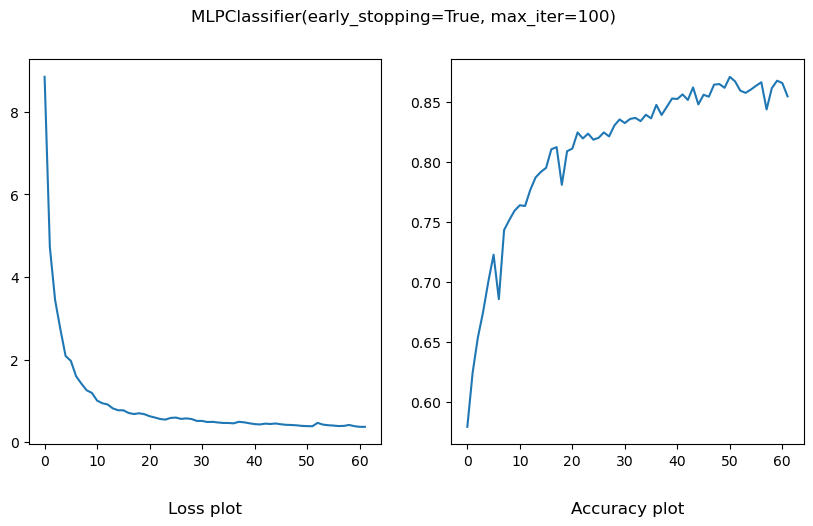

In [26]:
mlp = MLPClassifier(max_iter=100, early_stopping = True)
score = evaluate(mlp, train_df, min_max, 'Botanical Name')

loss_curve = mlp.loss_curve_
acc_score = mlp.validation_scores_
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(loss_curve, ax = ax1)
ax1.set_title("Loss plot", y = -0.2)
sns.lineplot(acc_score, ax = ax2)
ax2.set_title("Accuracy plot", y = -0.2)
fig.suptitle(f'{mlp}')
plt.show()

performance.append(('MLPClassifier', score))

In [27]:
knn = KNeighborsClassifier(3)
score = evaluate(knn, train_df, min_max, 'Botanical Name')
print("accuracy = ", score)

with open('knn.pickle', 'wb') as file:
    pickle.dump(knn, file = file)

performance.append(('KNeighborsClassifer', score))

x train shape =  (99846, 24)
y train shape =  (99846,)
x test shape =  (33283, 24)
y test shape =  (33283,)
Score =  0.768410299552324
accuracy =  0.768410299552324


In [28]:
tree = DecisionTreeClassifier(max_depth=20, random_state=42)
score = evaluate(tree, train_df, min_max, 'Botanical Name')
with open('tree.pickle', 'wb') as file:
    pickle.dump(tree, file = file)
performance.append(('DecisionTreeClassifier', score))

x train shape =  (99846, 24)
y train shape =  (99846,)
x test shape =  (33283, 24)
y test shape =  (33283,)
Score =  0.9965748279902653


In [29]:
forest = RandomForestClassifier(max_depth=20, n_estimators=20, max_features=1, random_state=4)
score = evaluate(forest, train_df, min_max, 'Botanical Name')
print('Score = ', score)
with open('forest.pickle', 'wb') as file:
    pickle.dump(forest, file = file)
performance.append(('RandomForestClassifer', score))

x train shape =  (99846, 24)
y train shape =  (99846,)
x test shape =  (33283, 24)
y test shape =  (33283,)
Score =  0.9026830514076255
Score =  0.9026830514076255


In [30]:
nb = GaussianNB()
score = evaluate(nb, train_df, min_max, 'Botanical Name')
print('Score = ', score)
with open('naive_bayse.pickle', 'wb') as file:
    pickle.dump(nb, file = file)
performance.append(('GaussianNB', score))

x train shape =  (99846, 24)
y train shape =  (99846,)
x test shape =  (33283, 24)
y test shape =  (33283,)
Score =  0.3347054051617943
Score =  0.3347054051617943


### Accuracy plots for all methods used

In [31]:
print(performance)

[('MLPClassifier', 0.866778836042424), ('KNeighborsClassifer', 0.768410299552324), ('DecisionTreeClassifier', 0.9965748279902653), ('RandomForestClassifer', 0.9026830514076255), ('GaussianNB', 0.3347054051617943)]


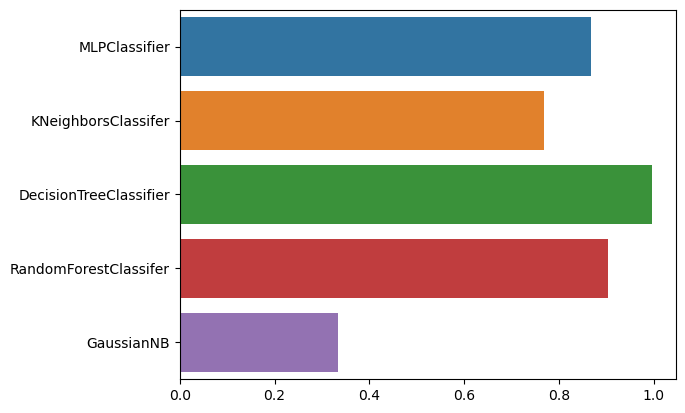

In [32]:
names = []
scores = []
for name, score in performance:
    names.append(name)
    scores.append(score)

sns.barplot(x = scores, y = names, orient = 'h')
plt.show()
    


### NN with Torch

In [33]:
target = 'Botanical Name'
features = train_df.drop(target, axis = 1)
labels = train_df[target]
num_class = len(labels.unique())

features = min_max(features)

x_train, x_test, y_train, y_test = train_test_split(features,labels, shuffle = True)
print('x train shape = ', x_train.shape)
print('y train shape = ', y_train.shape)
print('x test shape = ', x_test.shape)
print('y test shape = ', y_test.shape)
print('num class = ', num_class)

x train shape =  (99846, 24)
y train shape =  (99846,)
x test shape =  (33283, 24)
y test shape =  (33283,)
num class =  321


In [34]:
class TreeDataset(Dataset):
  def __init__(self, x_train, y_train, device):
    self.x = torch.tensor(x_train.to_numpy(), device = device).type(torch.float)
    self.y = torch.tensor(y_train.to_numpy(), device = device).type(torch.long)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

  def get_dataloader(self, batch_size = 1024, is_test = False):
    if is_test:
      batch_size = len(self.x)

    dataloader =  DataLoader(self, batch_size = batch_size, shuffle = True)
    return dataloader


train_data = TreeDataset(x_train, y_train, DEVICE)
test_data = TreeDataset(x_test, y_test, DEVICE)
train_dataloader = train_data.get_dataloader()
print('train size = ', len(train_dataloader))
test_dataloader = test_data.get_dataloader(is_test = True)
print('test size = ', len(test_dataloader))

train size =  98
test size =  1


In [ ]:
def accuracy(model, test_dataloader):
  x,y = next(iter(test_dataloader))
  y = y.cpu().numpy()
  y_pred = model(x)
  y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis = 1)
  return accuracy_score(y, y_pred)

def evaluate(model, train_dataloader, test_dataloader, optim, criterion, epochs = 50):
  history = []

  for e in range(epochs):
    print("EPOCH = ", e)
    running_loss = 0.0
    for x,y in tqdm(train_dataloader):
      y_pred = model(x)
      loss = criterion(y_pred, y)
      optim.zero_grad()
      loss.backward()
      optim.step()
      running_loss += loss.item()

    #measure accuracy
    score = accuracy(model, test_dataloader)
    history.append({'loss': running_loss, 'accuracy':score})
    print(f'e={e}, loss = {running_loss}, accuracy = {score}')
  
  return history

### Baseline

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 133129, 64]           1,600
              ReLU-2           [-1, 133129, 64]               0
            Linear-3          [-1, 133129, 321]          20,865
Total params: 22,465
Trainable params: 22,465
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.19
Forward/backward pass size (MB): 456.05
Params size (MB): 0.09
Estimated Total Size (MB): 468.32
----------------------------------------------------------------
EPOCH =  0


  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [00:01<00:00, 87.64it/s] 


e=0, loss = 248.41194891929626, accuracy = 0.6026800468707749
EPOCH =  1


100%|██████████| 98/98 [00:00<00:00, 100.34it/s]


e=1, loss = 156.05585300922394, accuracy = 0.668148904846318
EPOCH =  2


100%|██████████| 98/98 [00:01<00:00, 95.03it/s] 


e=2, loss = 127.3031222820282, accuracy = 0.7115043716011177
EPOCH =  3


100%|██████████| 98/98 [00:01<00:00, 96.63it/s] 


e=3, loss = 111.31400316953659, accuracy = 0.7289607307033621
EPOCH =  4


100%|██████████| 98/98 [00:00<00:00, 108.91it/s]


e=4, loss = 100.10455757379532, accuracy = 0.7499323979208605
EPOCH =  5


100%|██████████| 98/98 [00:00<00:00, 104.14it/s]


e=5, loss = 91.87298667430878, accuracy = 0.7570831956253944
EPOCH =  6


100%|██████████| 98/98 [00:01<00:00, 97.43it/s] 


e=6, loss = 86.01019078493118, accuracy = 0.7674488477601178
EPOCH =  7


100%|██████████| 98/98 [00:01<00:00, 94.97it/s] 


e=7, loss = 81.14370054006577, accuracy = 0.7754709611513385
EPOCH =  8


100%|██████████| 98/98 [00:01<00:00, 85.66it/s]


e=8, loss = 77.10194706916809, accuracy = 0.7861971577081392
EPOCH =  9


100%|██████████| 98/98 [00:00<00:00, 103.99it/s]


e=9, loss = 73.87442249059677, accuracy = 0.7929273202535829
EPOCH =  10


100%|██████████| 98/98 [00:01<00:00, 97.05it/s] 


e=10, loss = 71.11464434862137, accuracy = 0.7951206321545534
EPOCH =  11


100%|██████████| 98/98 [00:01<00:00, 78.52it/s] 


e=11, loss = 68.74362581968307, accuracy = 0.8009193882762972
EPOCH =  12


100%|██████████| 98/98 [00:00<00:00, 108.99it/s]


e=12, loss = 66.5088427066803, accuracy = 0.8084908211399213
EPOCH =  13


100%|██████████| 98/98 [00:00<00:00, 107.10it/s]


e=13, loss = 64.84228676557541, accuracy = 0.8120361746236817
EPOCH =  14


100%|██████████| 98/98 [00:01<00:00, 91.32it/s] 


e=14, loss = 62.990614235401154, accuracy = 0.811645584833098
EPOCH =  15


100%|██████████| 98/98 [00:00<00:00, 100.04it/s]


e=15, loss = 61.31744432449341, accuracy = 0.8153411651593907
EPOCH =  16


100%|██████████| 98/98 [00:00<00:00, 102.09it/s]


e=16, loss = 60.279434978961945, accuracy = 0.8191869723282156
EPOCH =  17


100%|██████████| 98/98 [00:01<00:00, 97.92it/s] 


e=17, loss = 58.78822982311249, accuracy = 0.8163026169515969
EPOCH =  18


100%|██████████| 98/98 [00:00<00:00, 107.57it/s]


e=18, loss = 57.692351281642914, accuracy = 0.8268785866658654
EPOCH =  19


100%|██████████| 98/98 [00:00<00:00, 111.68it/s]


e=19, loss = 56.76121887564659, accuracy = 0.8223116906528859
EPOCH =  20


100%|██████████| 98/98 [00:00<00:00, 98.68it/s] 


e=20, loss = 55.54666545987129, accuracy = 0.827930174563591
EPOCH =  21


100%|██████████| 98/98 [00:00<00:00, 105.32it/s]


e=21, loss = 54.70247536897659, accuracy = 0.8307243938346904
EPOCH =  22


100%|██████████| 98/98 [00:00<00:00, 99.87it/s] 


e=22, loss = 53.72446444630623, accuracy = 0.8397680497551302
EPOCH =  23


100%|██████████| 98/98 [00:01<00:00, 93.42it/s] 


e=23, loss = 53.007945746183395, accuracy = 0.8301234864645615
EPOCH =  24


100%|██████████| 98/98 [00:00<00:00, 108.84it/s]


e=24, loss = 52.327765583992004, accuracy = 0.8356518342697473
EPOCH =  25


100%|██████████| 98/98 [00:00<00:00, 105.82it/s]


e=25, loss = 51.70653137564659, accuracy = 0.8399182765976625
EPOCH =  26


100%|██████████| 98/98 [00:01<00:00, 93.12it/s] 


e=26, loss = 50.94880884885788, accuracy = 0.8408496830213622
EPOCH =  27


100%|██████████| 98/98 [00:00<00:00, 104.64it/s]


e=27, loss = 50.2994649708271, accuracy = 0.8440344920830454
EPOCH =  28


100%|██████████| 98/98 [00:00<00:00, 102.19it/s]


e=28, loss = 49.63924580812454, accuracy = 0.8391370970164949
EPOCH =  29


100%|██████████| 98/98 [00:01<00:00, 94.01it/s] 


e=29, loss = 48.92862969636917, accuracy = 0.8477300724093381
EPOCH =  30


100%|██████████| 98/98 [00:00<00:00, 110.97it/s]


e=30, loss = 48.41129609942436, accuracy = 0.8428927680798005
EPOCH =  31


100%|██████████| 98/98 [00:00<00:00, 107.00it/s]


e=31, loss = 47.68998309969902, accuracy = 0.8524772406333564
EPOCH =  32


100%|██████████| 98/98 [00:01<00:00, 89.41it/s] 


e=32, loss = 47.26804140210152, accuracy = 0.8528978757924466
EPOCH =  33


100%|██████████| 98/98 [00:00<00:00, 102.34it/s]


e=33, loss = 46.60916802287102, accuracy = 0.8503740648379052
EPOCH =  34


100%|██████████| 98/98 [00:00<00:00, 109.27it/s]


e=34, loss = 46.45032745599747, accuracy = 0.8587266772826969
EPOCH =  35


100%|██████████| 98/98 [00:01<00:00, 92.59it/s] 


e=35, loss = 45.834905087947845, accuracy = 0.8564131839077006
EPOCH =  36


100%|██████████| 98/98 [00:00<00:00, 102.21it/s]


e=36, loss = 45.68204775452614, accuracy = 0.8564732746447136
EPOCH =  37


100%|██████████| 98/98 [00:00<00:00, 101.00it/s]


e=37, loss = 44.89281162619591, accuracy = 0.8580055884385422
EPOCH =  38


100%|██████████| 98/98 [00:01<00:00, 93.18it/s] 


e=38, loss = 44.31944012641907, accuracy = 0.8619715770813929
EPOCH =  39


100%|██████████| 98/98 [00:00<00:00, 106.57it/s]


e=39, loss = 43.88822954893112, accuracy = 0.8610401706576931
EPOCH =  40


100%|██████████| 98/98 [00:00<00:00, 98.94it/s] 


e=40, loss = 43.65464508533478, accuracy = 0.8610702160261996
EPOCH =  41


100%|██████████| 98/98 [00:01<00:00, 90.66it/s] 


e=41, loss = 43.42202469706535, accuracy = 0.8556320043265331
EPOCH =  42


100%|██████████| 98/98 [00:00<00:00, 101.05it/s]


e=42, loss = 43.25947421789169, accuracy = 0.8609199891836673
EPOCH =  43


100%|██████████| 98/98 [00:00<00:00, 103.04it/s]


e=43, loss = 42.58269375562668, accuracy = 0.8624823483460025
EPOCH =  44


100%|██████████| 98/98 [00:01<00:00, 90.57it/s] 


e=44, loss = 42.304423809051514, accuracy = 0.8665985638313853
EPOCH =  45


100%|██████████| 98/98 [00:00<00:00, 102.44it/s]


e=45, loss = 41.90132233500481, accuracy = 0.8610401706576931
EPOCH =  46


100%|██████████| 98/98 [00:00<00:00, 100.50it/s]


e=46, loss = 41.46256875991821, accuracy = 0.8590271309677613
EPOCH =  47


100%|██████████| 98/98 [00:01<00:00, 90.75it/s] 


e=47, loss = 41.16762179136276, accuracy = 0.8661779286722951
EPOCH =  48


100%|██████████| 98/98 [00:00<00:00, 103.59it/s]


e=48, loss = 40.950317323207855, accuracy = 0.8699035543670943
EPOCH =  49


100%|██████████| 98/98 [00:00<00:00, 100.98it/s]


e=49, loss = 40.49768590927124, accuracy = 0.8678304239401496


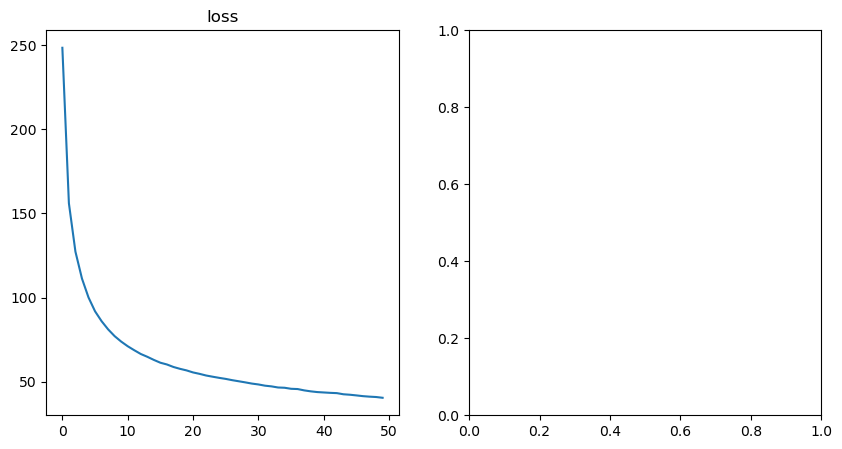

In [70]:
model = nn.Sequential(
    nn.LazyLinear(64),
    nn.ReLU(),
    nn.LazyLinear(num_class),
)

model.to(DEVICE)
summary(model, input_size = (features.shape))

# optim = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=1.9)
optim = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

history = evaluate(model, train_dataloader, test_dataloader, optim, criterion, epochs = 50)

losses = []
acc = []
e = []
for i, d in enumerate(history):
  l = d['loss']
  a = d['accuracy']
  e.append(i)
  losses.append(l)
  acc.append(a)

fig, (ax0, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(losses, ax = ax0)
ax0.set_title("loss")
sns.lineplot(acc, ax = ax1)
ax1.set_title("accuracy")
plt.show()

torch.save(model, 'nn.49epoch.h5')


### Hyperparms tunning

#### Exp 1: Add 1 hidden layers

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 133129, 32]             800
              ReLU-2           [-1, 133129, 32]               0
            Linear-3           [-1, 133129, 64]           2,112
              ReLU-4           [-1, 133129, 64]               0
            Linear-5          [-1, 133129, 321]          20,865
Total params: 23,777
Trainable params: 23,777
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.19
Forward/backward pass size (MB): 521.05
Params size (MB): 0.09
Estimated Total Size (MB): 533.33
----------------------------------------------------------------
EPOCH =  0


100%|██████████| 98/98 [00:01<00:00, 80.57it/s]


e=0, loss = 251.18320167064667, accuracy = 0.5973019259081213
EPOCH =  1


100%|██████████| 98/98 [00:00<00:00, 103.34it/s]


e=1, loss = 150.70284271240234, accuracy = 0.6883393924826487
EPOCH =  2


100%|██████████| 98/98 [00:00<00:00, 108.32it/s]


e=2, loss = 110.15552788972855, accuracy = 0.7341285340864706
EPOCH =  3


100%|██████████| 98/98 [00:01<00:00, 91.69it/s] 


e=3, loss = 90.9571743607521, accuracy = 0.7633025869062284
EPOCH =  4


100%|██████████| 98/98 [00:01<00:00, 89.53it/s] 


e=4, loss = 78.99458247423172, accuracy = 0.7818706246432112
EPOCH =  5


100%|██████████| 98/98 [00:00<00:00, 102.60it/s]


e=5, loss = 71.40769666433334, accuracy = 0.7987260763753268
EPOCH =  6


100%|██████████| 98/98 [00:00<00:00, 101.79it/s]


e=6, loss = 66.17712664604187, accuracy = 0.8084908211399213
EPOCH =  7


100%|██████████| 98/98 [00:00<00:00, 105.59it/s]


e=7, loss = 62.21827667951584, accuracy = 0.8233933239191179
EPOCH =  8


100%|██████████| 98/98 [00:01<00:00, 93.32it/s] 


e=8, loss = 58.88716369867325, accuracy = 0.8282306282486555
EPOCH =  9


100%|██████████| 98/98 [00:01<00:00, 92.31it/s] 


e=9, loss = 56.60061413049698, accuracy = 0.8296427605684584
EPOCH =  10


100%|██████████| 98/98 [00:00<00:00, 102.14it/s]


e=10, loss = 54.387492656707764, accuracy = 0.8449358531382387
EPOCH =  11


100%|██████████| 98/98 [00:00<00:00, 100.28it/s]


e=11, loss = 52.336011916399, accuracy = 0.8461376678784965
EPOCH =  12


100%|██████████| 98/98 [00:01<00:00, 94.23it/s] 


e=12, loss = 50.72504472732544, accuracy = 0.826578132980801
EPOCH =  13


100%|██████████| 98/98 [00:00<00:00, 105.82it/s]


e=13, loss = 49.60071235895157, accuracy = 0.8457170327194063
EPOCH =  14


100%|██████████| 98/98 [00:00<00:00, 101.35it/s]


e=14, loss = 47.600720316171646, accuracy = 0.8582759967551002
EPOCH =  15


100%|██████████| 98/98 [00:01<00:00, 92.33it/s] 


e=15, loss = 46.61214879155159, accuracy = 0.8549409608508849
EPOCH =  16


100%|██████████| 98/98 [00:00<00:00, 104.10it/s]


e=16, loss = 45.52542096376419, accuracy = 0.8565333653817264
EPOCH =  17


100%|██████████| 98/98 [00:00<00:00, 102.11it/s]


e=17, loss = 44.850244015455246, accuracy = 0.8567436829612716
EPOCH =  18


100%|██████████| 98/98 [00:01<00:00, 91.94it/s] 


e=18, loss = 43.78295361995697, accuracy = 0.8574046810684133
EPOCH =  19


100%|██████████| 98/98 [00:00<00:00, 102.69it/s]


e=19, loss = 42.480018734931946, accuracy = 0.8611903975002253
EPOCH =  20


100%|██████████| 98/98 [00:00<00:00, 107.28it/s]


e=20, loss = 42.622807174921036, accuracy = 0.8626626205570411
EPOCH =  21


100%|██████████| 98/98 [00:01<00:00, 91.95it/s] 


e=21, loss = 41.74989292025566, accuracy = 0.8617612595018478
EPOCH =  22


100%|██████████| 98/98 [00:00<00:00, 102.34it/s]


e=22, loss = 52.973433792591095, accuracy = 0.8539795090586786
EPOCH =  23


100%|██████████| 98/98 [00:00<00:00, 100.88it/s]


e=23, loss = 41.42143875360489, accuracy = 0.858936994862242
EPOCH =  24


100%|██████████| 98/98 [00:01<00:00, 91.74it/s] 


e=24, loss = 39.67624866962433, accuracy = 0.8655469759336598
EPOCH =  25


100%|██████████| 98/98 [00:00<00:00, 106.15it/s]


e=25, loss = 39.68020462989807, accuracy = 0.8696031006820298
EPOCH =  26


100%|██████████| 98/98 [00:00<00:00, 102.02it/s]


e=26, loss = 38.68754184246063, accuracy = 0.8703241895261845
EPOCH =  27


100%|██████████| 98/98 [00:01<00:00, 89.05it/s] 


e=27, loss = 38.805220514535904, accuracy = 0.8600486734969804
EPOCH =  28


100%|██████████| 98/98 [00:00<00:00, 101.97it/s]


e=28, loss = 37.917961567640305, accuracy = 0.8754319021722802
EPOCH =  29


100%|██████████| 98/98 [00:00<00:00, 104.27it/s]


e=29, loss = 37.252179473638535, accuracy = 0.8763933539644864
EPOCH =  30


100%|██████████| 98/98 [00:01<00:00, 92.49it/s] 


e=30, loss = 37.095327228307724, accuracy = 0.8739596791154643
EPOCH =  31


100%|██████████| 98/98 [00:00<00:00, 101.86it/s]


e=31, loss = 37.2612347304821, accuracy = 0.876573626175525
EPOCH =  32


100%|██████████| 98/98 [00:00<00:00, 101.66it/s]


e=32, loss = 35.75737735629082, accuracy = 0.8733587717453355
EPOCH =  33


100%|██████████| 98/98 [00:01<00:00, 91.41it/s] 


e=33, loss = 36.14730063080788, accuracy = 0.8764233993329928
EPOCH =  34


100%|██████████| 98/98 [00:01<00:00, 97.96it/s] 


e=34, loss = 35.8947816491127, accuracy = 0.8705044617372232
EPOCH =  35


100%|██████████| 98/98 [00:00<00:00, 100.80it/s]


e=35, loss = 34.89973220229149, accuracy = 0.8751915392242285
EPOCH =  36


100%|██████████| 98/98 [00:01<00:00, 92.69it/s] 


e=36, loss = 34.74852964282036, accuracy = 0.8750713577502028
EPOCH =  37


100%|██████████| 98/98 [00:00<00:00, 98.45it/s] 


e=37, loss = 34.259798526763916, accuracy = 0.8807499323979209
EPOCH =  38


100%|██████████| 98/98 [00:00<00:00, 102.77it/s]


e=38, loss = 34.34326860308647, accuracy = 0.8788871195505212
EPOCH =  39


100%|██████████| 98/98 [00:01<00:00, 92.91it/s] 


e=39, loss = 34.45204049348831, accuracy = 0.8889222726316738
EPOCH =  40


100%|██████████| 98/98 [00:00<00:00, 100.70it/s]


e=40, loss = 34.79422241449356, accuracy = 0.881230658294024
EPOCH =  41


100%|██████████| 98/98 [00:00<00:00, 103.70it/s]


e=41, loss = 33.238883286714554, accuracy = 0.8832737433524622
EPOCH =  42


100%|██████████| 98/98 [00:01<00:00, 90.41it/s] 


e=42, loss = 48.85793912410736, accuracy = 0.8341796112129315
EPOCH =  43


100%|██████████| 98/98 [00:00<00:00, 101.93it/s]


e=43, loss = 35.48705753684044, accuracy = 0.8850464200943424
EPOCH =  44


100%|██████████| 98/98 [00:00<00:00, 103.81it/s]


e=44, loss = 32.20242491364479, accuracy = 0.8922573085358891
EPOCH =  45


100%|██████████| 98/98 [00:01<00:00, 90.16it/s] 


e=45, loss = 32.00738878548145, accuracy = 0.8785265751284439
EPOCH =  46


100%|██████████| 98/98 [00:00<00:00, 101.94it/s]


e=46, loss = 32.11376176774502, accuracy = 0.8922873539043956
EPOCH =  47


100%|██████████| 98/98 [00:00<00:00, 103.87it/s]


e=47, loss = 31.296682953834534, accuracy = 0.8848361025147974
EPOCH =  48


100%|██████████| 98/98 [00:01<00:00, 89.01it/s] 


e=48, loss = 31.6653311252594, accuracy = 0.8906949493735541
EPOCH =  49


100%|██████████| 98/98 [00:00<00:00, 101.11it/s]


e=49, loss = 31.533643305301666, accuracy = 0.8952918907550401


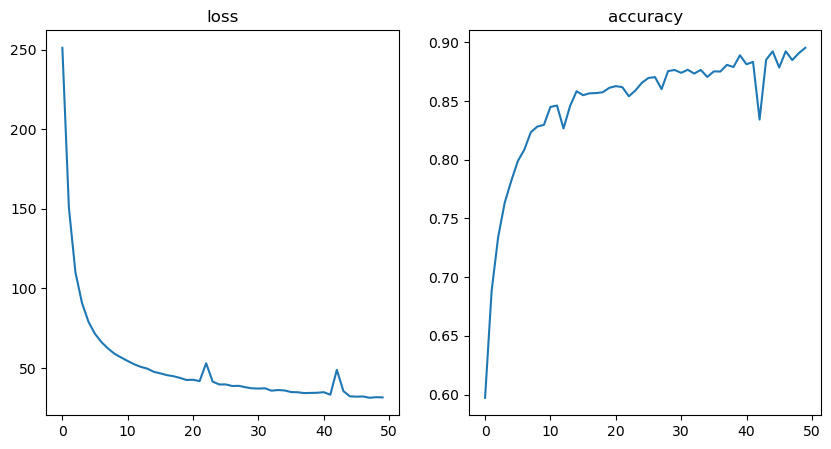

In [71]:
del model

model1 = nn.Sequential(
    nn.LazyLinear(32),
    nn.ReLU(),
    nn.LazyLinear(64),
    nn.ReLU(),
    nn.LazyLinear(num_class),
)

model1.to(DEVICE)
summary(model1, input_size = (features.shape))

optim = torch.optim.Adam(model1.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

history1 = evaluate(model1, train_dataloader, test_dataloader, optim, criterion, epochs = 50)

losses = []
acc = []
e = []
for i, d in enumerate(history1):
  l = d['loss']
  a = d['accuracy']
  e.append(i)
  losses.append(l)
  acc.append(a)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(losses, ax = ax1)
ax1.set_title("loss")
sns.lineplot(acc, ax = ax2)
ax2.set_title("accuracy")
plt.show()

torch.save(model1, 'nn1.50epoch.h5')

### EXP 2: Using 3 hidden layers

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 133129, 32]             800
              ReLU-2           [-1, 133129, 32]               0
            Linear-3           [-1, 133129, 64]           2,112
              ReLU-4           [-1, 133129, 64]               0
            Linear-5          [-1, 133129, 128]           8,320
              ReLU-6          [-1, 133129, 128]               0
            Linear-7          [-1, 133129, 321]          41,409
Total params: 52,641
Trainable params: 52,641
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.19
Forward/backward pass size (MB): 781.07
Params size (MB): 0.20
Estimated Total Size (MB): 793.46
----------------------------------------------------------------
EPOCH =  0


100%|██████████| 98/98 [00:01<00:00, 92.75it/s] 


e=0, loss = 238.2769055366516, accuracy = 0.5869963645104107
EPOCH =  1


100%|██████████| 98/98 [00:00<00:00, 99.74it/s] 


e=1, loss = 144.6558314561844, accuracy = 0.7153201334014362
EPOCH =  2


100%|██████████| 98/98 [00:01<00:00, 92.35it/s]


e=2, loss = 97.75526118278503, accuracy = 0.7636330859597993
EPOCH =  3


100%|██████████| 98/98 [00:00<00:00, 98.40it/s] 


e=3, loss = 89.14562028646469, accuracy = 0.7632124508007091
EPOCH =  4


100%|██████████| 98/98 [00:01<00:00, 87.86it/s]


e=4, loss = 72.14757961034775, accuracy = 0.8047351500766157
EPOCH =  5


100%|██████████| 98/98 [00:00<00:00, 98.79it/s] 


e=5, loss = 58.809579491615295, accuracy = 0.8254664543460626
EPOCH =  6


100%|██████████| 98/98 [00:00<00:00, 100.87it/s]


e=6, loss = 53.165956884622574, accuracy = 0.83664333143046
EPOCH =  7


100%|██████████| 98/98 [00:01<00:00, 95.78it/s] 


e=7, loss = 49.771918058395386, accuracy = 0.8311149836252741
EPOCH =  8


100%|██████████| 98/98 [00:00<00:00, 98.83it/s] 


e=8, loss = 46.165794759988785, accuracy = 0.8608598984466544
EPOCH =  9


100%|██████████| 98/98 [00:01<00:00, 96.33it/s] 


e=9, loss = 45.3335964679718, accuracy = 0.8639245260343118
EPOCH =  10


100%|██████████| 98/98 [00:00<00:00, 98.68it/s] 


e=10, loss = 41.84125858545303, accuracy = 0.8468587567226512
EPOCH =  11


100%|██████████| 98/98 [00:01<00:00, 88.03it/s]


e=11, loss = 81.37948277592659, accuracy = 0.8353513805846828
EPOCH =  12


100%|██████████| 98/98 [00:01<00:00, 97.95it/s] 


e=12, loss = 43.16063058376312, accuracy = 0.864885977826518
EPOCH =  13


100%|██████████| 98/98 [00:00<00:00, 98.98it/s] 


e=13, loss = 39.443212658166885, accuracy = 0.8811705675570111
EPOCH =  14


100%|██████████| 98/98 [00:01<00:00, 95.04it/s] 


e=14, loss = 38.85133734345436, accuracy = 0.8677703332031368
EPOCH =  15


100%|██████████| 98/98 [00:00<00:00, 99.52it/s] 


e=15, loss = 37.42208793759346, accuracy = 0.8416008172340234
EPOCH =  16


100%|██████████| 98/98 [00:01<00:00, 96.65it/s] 


e=16, loss = 37.086552530527115, accuracy = 0.8706847339482618
EPOCH =  17


100%|██████████| 98/98 [00:00<00:00, 98.58it/s] 


e=17, loss = 34.98030126094818, accuracy = 0.8726977736381937
EPOCH =  18


100%|██████████| 98/98 [00:01<00:00, 87.56it/s]


e=18, loss = 104.4337377846241, accuracy = 0.832046390048974
EPOCH =  19


100%|██████████| 98/98 [00:01<00:00, 96.68it/s] 


e=19, loss = 44.93558567762375, accuracy = 0.8626025298200283
EPOCH =  20


100%|██████████| 98/98 [00:00<00:00, 99.15it/s] 


e=20, loss = 38.10619378089905, accuracy = 0.8805095694498694
EPOCH =  21


100%|██████████| 98/98 [00:00<00:00, 98.60it/s] 


e=21, loss = 38.17142879962921, accuracy = 0.8758224919628639
EPOCH =  22


100%|██████████| 98/98 [00:01<00:00, 97.52it/s] 


e=22, loss = 35.650747418403625, accuracy = 0.8872998227323258
EPOCH =  23


100%|██████████| 98/98 [00:00<00:00, 100.03it/s]


e=23, loss = 36.31594035029411, accuracy = 0.8784965297599375
EPOCH =  24


100%|██████████| 98/98 [00:00<00:00, 98.22it/s] 


e=24, loss = 32.95476683974266, accuracy = 0.8970645674969203
EPOCH =  25


100%|██████████| 98/98 [00:01<00:00, 89.06it/s] 


e=25, loss = 32.22540158033371, accuracy = 0.8992278340293843
EPOCH =  26


100%|██████████| 98/98 [00:00<00:00, 100.31it/s]


e=26, loss = 31.84621423482895, accuracy = 0.8900039058979058
EPOCH =  27


100%|██████████| 98/98 [00:00<00:00, 99.26it/s] 


e=27, loss = 32.06913746893406, accuracy = 0.9069494937355407
EPOCH =  28


100%|██████████| 98/98 [00:01<00:00, 97.31it/s] 


e=28, loss = 29.65464609861374, accuracy = 0.9064387224709312
EPOCH =  29


100%|██████████| 98/98 [00:00<00:00, 99.58it/s] 


e=29, loss = 29.744362846016884, accuracy = 0.7969233542649401
EPOCH =  30


100%|██████████| 98/98 [00:00<00:00, 100.44it/s]


e=30, loss = 56.20558765530586, accuracy = 0.894540756542379
EPOCH =  31


100%|██████████| 98/98 [00:00<00:00, 98.80it/s] 


e=31, loss = 31.3789541721344, accuracy = 0.8834239701949944
EPOCH =  32


100%|██████████| 98/98 [00:01<00:00, 84.45it/s]


e=32, loss = 27.972751095891, accuracy = 0.9096836222696272
EPOCH =  33


100%|██████████| 98/98 [00:00<00:00, 99.02it/s] 


e=33, loss = 34.01791101694107, accuracy = 0.884745966409278
EPOCH =  34


100%|██████████| 98/98 [00:00<00:00, 98.82it/s] 


e=34, loss = 26.506617829203606, accuracy = 0.9154222876543581
EPOCH =  35


100%|██████████| 98/98 [00:00<00:00, 98.50it/s] 


e=35, loss = 25.33068424463272, accuracy = 0.9159931496559806
EPOCH =  36


100%|██████████| 98/98 [00:00<00:00, 100.70it/s]


e=36, loss = 36.241586089134216, accuracy = 0.9070095844725535
EPOCH =  37


100%|██████████| 98/98 [00:01<00:00, 97.07it/s]


e=37, loss = 25.18291002511978, accuracy = 0.8860078718865487
EPOCH =  38


100%|██████████| 98/98 [00:01<00:00, 97.16it/s] 


e=38, loss = 24.97813130915165, accuracy = 0.8884415467355707
EPOCH =  39


100%|██████████| 98/98 [00:01<00:00, 86.41it/s]


e=39, loss = 29.26999993622303, accuracy = 0.9049965447826217
EPOCH =  40


100%|██████████| 98/98 [00:00<00:00, 101.16it/s]


e=40, loss = 23.635750114917755, accuracy = 0.9181263708199381
EPOCH =  41


100%|██████████| 98/98 [00:00<00:00, 99.44it/s] 


e=41, loss = 29.879945784807205, accuracy = 0.8044647417600577
EPOCH =  42


100%|██████████| 98/98 [00:01<00:00, 97.11it/s]


e=42, loss = 28.27528588473797, accuracy = 0.9122374785926749
EPOCH =  43


100%|██████████| 98/98 [00:00<00:00, 98.74it/s] 


e=43, loss = 25.048412427306175, accuracy = 0.9265390740017426
EPOCH =  44


100%|██████████| 98/98 [00:00<00:00, 99.03it/s] 


e=44, loss = 23.00682459771633, accuracy = 0.8986870173962683
EPOCH =  45


100%|██████████| 98/98 [00:00<00:00, 98.26it/s] 


e=45, loss = 25.316463217139244, accuracy = 0.9173451912387706
EPOCH =  46


100%|██████████| 98/98 [00:01<00:00, 88.66it/s]


e=46, loss = 64.79432670772076, accuracy = 0.8533485563200432
EPOCH =  47


100%|██████████| 98/98 [00:00<00:00, 100.66it/s]


e=47, loss = 31.65618498623371, accuracy = 0.91109575458943
EPOCH =  48


100%|██████████| 98/98 [00:01<00:00, 95.25it/s]


e=48, loss = 25.685366973280907, accuracy = 0.9172550551332512
EPOCH =  49


100%|██████████| 98/98 [00:01<00:00, 93.60it/s]


e=49, loss = 23.52276960015297, accuracy = 0.9235645825196046


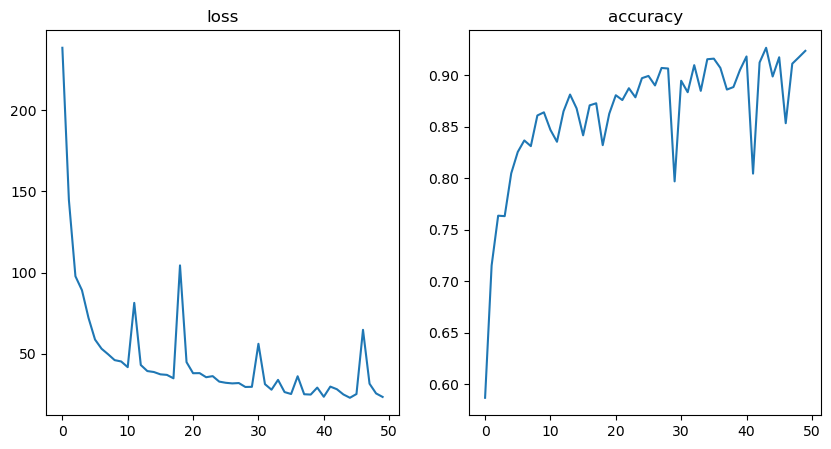

In [72]:
model2 = nn.Sequential(
    nn.LazyLinear(32),
    nn.ReLU(),
    nn.LazyLinear(64),
    nn.ReLU(),
    nn.LazyLinear(128),
    nn.ReLU(),
    nn.LazyLinear(num_class),
)

model2.to(DEVICE)
summary(model2, input_size = (features.shape))

optim = torch.optim.Adam(model2.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

history2 = evaluate(model2, train_dataloader, test_dataloader, optim, criterion, epochs = 50)

losses = []
acc = []
e = []
for i, d in enumerate(history2):
  l = d['loss']
  a = d['accuracy']
  e.append(i)
  losses.append(l)
  acc.append(a)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(losses, ax = ax1)
ax1.set_title("loss")
sns.lineplot(acc, ax = ax2)
ax2.set_title("accuracy")
plt.show()

torch.save(model2, 'nn1.50epoch.h5')

### Exp3: Learning rate = 0.001

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 133129, 64]           1,600
              ReLU-2           [-1, 133129, 64]               0
            Linear-3          [-1, 133129, 321]          20,865
Total params: 22,465
Trainable params: 22,465
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.19
Forward/backward pass size (MB): 456.05
Params size (MB): 0.09
Estimated Total Size (MB): 468.32
----------------------------------------------------------------
EPOCH =  0


100%|██████████| 98/98 [00:01<00:00, 94.35it/s] 


e=0, loss = 443.0342655181885, accuracy = 0.4506504822281645
EPOCH =  1


100%|██████████| 98/98 [00:00<00:00, 108.58it/s]


e=1, loss = 256.3078224658966, accuracy = 0.5204158279001292
EPOCH =  2


100%|██████████| 98/98 [00:00<00:00, 109.01it/s]


e=2, loss = 222.76681447029114, accuracy = 0.5548478202085149
EPOCH =  3


100%|██████████| 98/98 [00:00<00:00, 98.03it/s] 


e=3, loss = 208.45160710811615, accuracy = 0.561277529068894
EPOCH =  4


100%|██████████| 98/98 [00:00<00:00, 108.52it/s]


e=4, loss = 198.01241791248322, accuracy = 0.5776522549049065
EPOCH =  5


100%|██████████| 98/98 [00:00<00:00, 106.90it/s]


e=5, loss = 189.02548718452454, accuracy = 0.5985337860168854
EPOCH =  6


100%|██████████| 98/98 [00:00<00:00, 107.05it/s]


e=6, loss = 180.77085077762604, accuracy = 0.6035814079259683
EPOCH =  7


100%|██████████| 98/98 [00:00<00:00, 106.75it/s]


e=7, loss = 173.71854412555695, accuracy = 0.610792296367515
EPOCH =  8


100%|██████████| 98/98 [00:00<00:00, 104.55it/s]


e=8, loss = 167.5360630750656, accuracy = 0.6219090827148995
EPOCH =  9


100%|██████████| 98/98 [00:00<00:00, 103.46it/s]


e=9, loss = 162.10569536685944, accuracy = 0.6362106781239671
EPOCH =  10


100%|██████████| 98/98 [00:01<00:00, 97.48it/s] 


e=10, loss = 157.33404541015625, accuracy = 0.6434816573025268
EPOCH =  11


100%|██████████| 98/98 [00:00<00:00, 107.83it/s]


e=11, loss = 153.01297795772552, accuracy = 0.6489198690021933
EPOCH =  12


100%|██████████| 98/98 [00:00<00:00, 110.11it/s]


e=12, loss = 149.19069635868073, accuracy = 0.6520445873268635
EPOCH =  13


100%|██████████| 98/98 [00:00<00:00, 108.92it/s]


e=13, loss = 145.661438703537, accuracy = 0.6575428897635429
EPOCH =  14


100%|██████████| 98/98 [00:00<00:00, 105.72it/s]


e=14, loss = 142.40260875225067, accuracy = 0.6634618273593126
EPOCH =  15


100%|██████████| 98/98 [00:00<00:00, 108.26it/s]


e=15, loss = 139.42559921741486, accuracy = 0.66923053811255
EPOCH =  16


100%|██████████| 98/98 [00:00<00:00, 111.49it/s]


e=16, loss = 136.61458563804626, accuracy = 0.6710933509599495
EPOCH =  17


100%|██████████| 98/98 [00:01<00:00, 94.11it/s] 


e=17, loss = 133.94745552539825, accuracy = 0.6787849652975994
EPOCH =  18


100%|██████████| 98/98 [00:00<00:00, 111.67it/s]


e=18, loss = 131.57486307621002, accuracy = 0.6812486855151278
EPOCH =  19


100%|██████████| 98/98 [00:00<00:00, 112.38it/s]


e=19, loss = 129.15148413181305, accuracy = 0.683562178890124
EPOCH =  20


100%|██████████| 98/98 [00:00<00:00, 104.23it/s]


e=20, loss = 126.94831466674805, accuracy = 0.6921851996514737
EPOCH =  21


100%|██████████| 98/98 [00:00<00:00, 108.22it/s]


e=21, loss = 124.79172825813293, accuracy = 0.6930264699696542
EPOCH =  22


100%|██████████| 98/98 [00:00<00:00, 108.97it/s]


e=22, loss = 122.69881618022919, accuracy = 0.698825226091398
EPOCH =  23


100%|██████████| 98/98 [00:00<00:00, 102.27it/s]


e=23, loss = 120.73008823394775, accuracy = 0.7059459784274255
EPOCH =  24


100%|██████████| 98/98 [00:01<00:00, 93.72it/s] 


e=24, loss = 118.76033878326416, accuracy = 0.7091007421206021
EPOCH =  25


100%|██████████| 98/98 [00:00<00:00, 104.94it/s]


e=25, loss = 116.92664349079132, accuracy = 0.7103926929663792
EPOCH =  26


100%|██████████| 98/98 [00:00<00:00, 107.37it/s]


e=26, loss = 115.0687313079834, accuracy = 0.7154703602439684
EPOCH =  27


100%|██████████| 98/98 [00:00<00:00, 111.10it/s]


e=27, loss = 113.36075377464294, accuracy = 0.7218399783673347
EPOCH =  28


100%|██████████| 98/98 [00:00<00:00, 107.16it/s]


e=28, loss = 111.73941838741302, accuracy = 0.7208184358381156
EPOCH =  29


100%|██████████| 98/98 [00:00<00:00, 107.26it/s]


e=29, loss = 110.12875294685364, accuracy = 0.7270077817504431
EPOCH =  30


100%|██████████| 98/98 [00:00<00:00, 106.59it/s]


e=30, loss = 108.52458935976028, accuracy = 0.7293813658624523
EPOCH =  31


100%|██████████| 98/98 [00:01<00:00, 95.73it/s] 


e=31, loss = 107.05263763666153, accuracy = 0.7323258119760839
EPOCH =  32


100%|██████████| 98/98 [00:00<00:00, 108.62it/s]


e=32, loss = 105.58156925439835, accuracy = 0.7333173091367966
EPOCH =  33


100%|██████████| 98/98 [00:00<00:00, 110.06it/s]


e=33, loss = 104.21848404407501, accuracy = 0.7356007571432863
EPOCH =  34


100%|██████████| 98/98 [00:00<00:00, 110.47it/s]


e=34, loss = 102.78092163801193, accuracy = 0.7372532524111408
EPOCH =  35


100%|██████████| 98/98 [00:00<00:00, 110.16it/s]


e=35, loss = 101.56418085098267, accuracy = 0.7394766096806177
EPOCH =  36


100%|██████████| 98/98 [00:00<00:00, 107.15it/s]


e=36, loss = 100.30124282836914, accuracy = 0.74233091968873
EPOCH =  37


100%|██████████| 98/98 [00:00<00:00, 105.31it/s]


e=37, loss = 99.00716471672058, accuracy = 0.7421506474776913
EPOCH =  38


100%|██████████| 98/98 [00:01<00:00, 93.88it/s] 


e=38, loss = 97.84137892723083, accuracy = 0.7447045038007392
EPOCH =  39


100%|██████████| 98/98 [00:01<00:00, 94.61it/s]


e=39, loss = 96.687180519104, accuracy = 0.7449148213802842
EPOCH =  40


100%|██████████| 98/98 [00:00<00:00, 108.81it/s]


e=40, loss = 95.56730836629868, accuracy = 0.7486404470750834
EPOCH =  41


100%|██████████| 98/98 [00:00<00:00, 106.96it/s]


e=41, loss = 94.53885000944138, accuracy = 0.7506534867650152
EPOCH =  42


100%|██████████| 98/98 [00:00<00:00, 108.22it/s]


e=42, loss = 93.47243094444275, accuracy = 0.7510140311870925
EPOCH =  43


100%|██████████| 98/98 [00:00<00:00, 112.04it/s]


e=43, loss = 92.43133264780045, accuracy = 0.7544692485653337
EPOCH =  44


100%|██████████| 98/98 [00:00<00:00, 109.16it/s]


e=44, loss = 91.48931753635406, accuracy = 0.7569930595198751
EPOCH =  45


100%|██████████| 98/98 [00:01<00:00, 97.50it/s] 


e=45, loss = 90.54969125986099, accuracy = 0.7589159631042874
EPOCH =  46


100%|██████████| 98/98 [00:00<00:00, 107.77it/s]


e=46, loss = 89.548224568367, accuracy = 0.7601478232130517
EPOCH =  47


100%|██████████| 98/98 [00:00<00:00, 104.35it/s]


e=47, loss = 88.68628972768784, accuracy = 0.7621909082714899
EPOCH =  48


100%|██████████| 98/98 [00:00<00:00, 110.83it/s]


e=48, loss = 87.88976663351059, accuracy = 0.7653156265961601
EPOCH =  49


100%|██████████| 98/98 [00:00<00:00, 108.12it/s]


e=49, loss = 87.1257996559143, accuracy = 0.7662169876513536


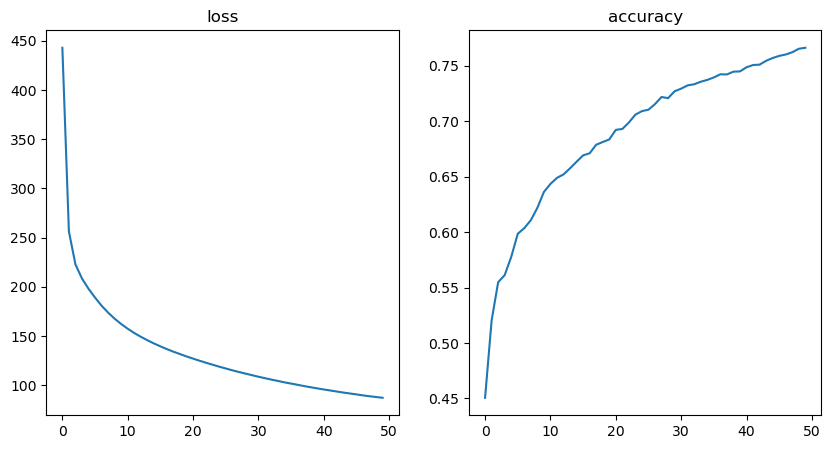

In [73]:

model3 = nn.Sequential(
    nn.LazyLinear(64),
    nn.ReLU(),
    nn.LazyLinear(num_class),
)

model3.to(DEVICE)
summary(model3, input_size = (features.shape))

optim = torch.optim.Adam(model3.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

history3 = evaluate(model3, train_dataloader, test_dataloader, optim, criterion, epochs = 50)

losses = []
acc = []
e = []
for i, d in enumerate(history3):
  l = d['loss']
  a = d['accuracy']
  e.append(i)
  losses.append(l)
  acc.append(a)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(losses, ax = ax1)
ax1.set_title("loss")
sns.lineplot(acc, ax = ax2)
ax2.set_title("accuracy")
plt.show()

torch.save(model3, 'nn2.50epoch.h5')

### Exp4: Using SGD as optimizer

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 133129, 64]           1,600
              ReLU-2           [-1, 133129, 64]               0
            Linear-3          [-1, 133129, 321]          20,865
Total params: 22,465
Trainable params: 22,465
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.19
Forward/backward pass size (MB): 456.05
Params size (MB): 0.09
Estimated Total Size (MB): 468.32
----------------------------------------------------------------
EPOCH =  0


100%|██████████| 98/98 [00:01<00:00, 92.47it/s] 


e=0, loss = 536.0894846916199, accuracy = 0.4506504822281645
EPOCH =  1


100%|██████████| 98/98 [00:01<00:00, 95.59it/s] 


e=1, loss = 406.39126801490784, accuracy = 0.4506504822281645
EPOCH =  2


100%|██████████| 98/98 [00:00<00:00, 111.84it/s]


e=2, loss = 346.3185076713562, accuracy = 0.4506504822281645
EPOCH =  3


100%|██████████| 98/98 [00:01<00:00, 95.40it/s] 


e=3, loss = 331.0163576602936, accuracy = 0.4506504822281645
EPOCH =  4


100%|██████████| 98/98 [00:00<00:00, 108.57it/s]


e=4, loss = 317.81055974960327, accuracy = 0.4506504822281645
EPOCH =  5


100%|██████████| 98/98 [00:00<00:00, 98.54it/s] 


e=5, loss = 306.3839762210846, accuracy = 0.4506504822281645
EPOCH =  6


100%|██████████| 98/98 [00:01<00:00, 94.45it/s] 


e=6, loss = 297.1573588848114, accuracy = 0.45185229696842233
EPOCH =  7


100%|██████████| 98/98 [00:00<00:00, 107.37it/s]


e=7, loss = 289.7350695133209, accuracy = 0.45536760508367635
EPOCH =  8


100%|██████████| 98/98 [00:00<00:00, 100.25it/s]


e=8, loss = 283.3108630180359, accuracy = 0.46020490941321396
EPOCH =  9


100%|██████████| 98/98 [00:01<00:00, 96.43it/s] 


e=9, loss = 277.5773138999939, accuracy = 0.46606375627197066
EPOCH =  10


100%|██████████| 98/98 [00:01<00:00, 95.47it/s] 


e=10, loss = 272.074599981308, accuracy = 0.47114142354955985
EPOCH =  11


100%|██████████| 98/98 [00:01<00:00, 89.74it/s]


e=11, loss = 267.2623152732849, accuracy = 0.4768500435657843
EPOCH =  12


100%|██████████| 98/98 [00:01<00:00, 93.56it/s] 


e=12, loss = 263.1550133228302, accuracy = 0.4817474386323348
EPOCH =  13


100%|██████████| 98/98 [00:01<00:00, 94.00it/s]


e=13, loss = 259.1574635505676, accuracy = 0.48613406243427576
EPOCH =  14


100%|██████████| 98/98 [00:01<00:00, 92.94it/s]


e=14, loss = 255.73375344276428, accuracy = 0.48934891686446536
EPOCH =  15


100%|██████████| 98/98 [00:01<00:00, 96.50it/s] 


e=15, loss = 252.82232284545898, accuracy = 0.49088123065829403
EPOCH =  16


100%|██████████| 98/98 [00:01<00:00, 92.90it/s] 


e=16, loss = 250.13268327713013, accuracy = 0.4938857675089385
EPOCH =  17


100%|██████████| 98/98 [00:01<00:00, 92.03it/s]


e=17, loss = 247.71674942970276, accuracy = 0.49761139320373765
EPOCH =  18


100%|██████████| 98/98 [00:01<00:00, 89.30it/s] 


e=18, loss = 245.63162541389465, accuracy = 0.5026289697443139
EPOCH =  19


100%|██████████| 98/98 [00:01<00:00, 96.54it/s]


e=19, loss = 243.71933937072754, accuracy = 0.506955502809242
EPOCH =  20


100%|██████████| 98/98 [00:01<00:00, 90.08it/s] 


e=20, loss = 241.9202287197113, accuracy = 0.5125439413514407
EPOCH =  21


100%|██████████| 98/98 [00:01<00:00, 91.45it/s] 


e=21, loss = 240.4880039691925, accuracy = 0.515127843042995
EPOCH =  22


100%|██████████| 98/98 [00:01<00:00, 94.69it/s] 


e=22, loss = 239.17960810661316, accuracy = 0.5152480245170207
EPOCH =  23


100%|██████████| 98/98 [00:00<00:00, 107.32it/s]


e=23, loss = 237.81469655036926, accuracy = 0.5272060811825857
EPOCH =  24


100%|██████████| 98/98 [00:01<00:00, 93.39it/s] 


e=24, loss = 236.6337583065033, accuracy = 0.5360394195234804
EPOCH =  25


100%|██████████| 98/98 [00:00<00:00, 107.67it/s]


e=25, loss = 235.61881113052368, accuracy = 0.5383829582669831
EPOCH =  26


100%|██████████| 98/98 [00:01<00:00, 93.08it/s] 


e=26, loss = 234.59688186645508, accuracy = 0.5477871586095003
EPOCH =  27


100%|██████████| 98/98 [00:01<00:00, 88.58it/s]


e=27, loss = 233.63408970832825, accuracy = 0.5492293362978097
EPOCH =  28


100%|██████████| 98/98 [00:01<00:00, 92.17it/s] 


e=28, loss = 232.7037012577057, accuracy = 0.5527145990445573
EPOCH =  29


100%|██████████| 98/98 [00:00<00:00, 108.89it/s]


e=29, loss = 231.85564351081848, accuracy = 0.5538262776792957
EPOCH =  30


100%|██████████| 98/98 [00:01<00:00, 95.45it/s] 


e=30, loss = 231.0487928390503, accuracy = 0.5543370489439053
EPOCH =  31


100%|██████████| 98/98 [00:00<00:00, 100.00it/s]


e=31, loss = 230.23848795890808, accuracy = 0.5527145990445573
EPOCH =  32


100%|██████████| 98/98 [00:01<00:00, 94.83it/s] 


e=32, loss = 229.44833755493164, accuracy = 0.5571012228464982
EPOCH =  33


100%|██████████| 98/98 [00:01<00:00, 91.52it/s] 


e=33, loss = 228.92663168907166, accuracy = 0.558573445903314
EPOCH =  34


100%|██████████| 98/98 [00:01<00:00, 97.23it/s] 


e=34, loss = 228.1890525817871, accuracy = 0.5595348976955202
EPOCH =  35


100%|██████████| 98/98 [00:00<00:00, 103.10it/s]


e=35, loss = 227.54437851905823, accuracy = 0.5604062133822071
EPOCH =  36


100%|██████████| 98/98 [00:01<00:00, 94.41it/s] 


e=36, loss = 226.8630075454712, accuracy = 0.5614878466484391
EPOCH =  37


100%|██████████| 98/98 [00:01<00:00, 97.58it/s] 


e=37, loss = 226.26281571388245, accuracy = 0.5616681188594778
EPOCH =  38


100%|██████████| 98/98 [00:01<00:00, 92.36it/s] 


e=38, loss = 225.7132110595703, accuracy = 0.5620286632815551
EPOCH =  39


100%|██████████| 98/98 [00:01<00:00, 91.17it/s] 


e=39, loss = 225.2115125656128, accuracy = 0.5612174383318811
EPOCH =  40


100%|██████████| 98/98 [00:01<00:00, 95.96it/s] 


e=40, loss = 224.60991549491882, accuracy = 0.5631403419162936
EPOCH =  41


100%|██████████| 98/98 [00:00<00:00, 112.72it/s]


e=41, loss = 224.04403114318848, accuracy = 0.5635309317068774
EPOCH =  42


100%|██████████| 98/98 [00:01<00:00, 97.10it/s] 


e=42, loss = 223.53166675567627, accuracy = 0.5643121112880449
EPOCH =  43


100%|██████████| 98/98 [00:00<00:00, 115.18it/s]


e=43, loss = 222.993994474411, accuracy = 0.5641618844455127
EPOCH =  44


100%|██████████| 98/98 [00:01<00:00, 91.29it/s]


e=44, loss = 222.57719659805298, accuracy = 0.5639215214974612
EPOCH =  45


100%|██████████| 98/98 [00:00<00:00, 98.85it/s] 


e=45, loss = 222.21978855133057, accuracy = 0.5652134723432383
EPOCH =  46


100%|██████████| 98/98 [00:01<00:00, 94.83it/s] 


e=46, loss = 221.65263605117798, accuracy = 0.5644923834990836
EPOCH =  47


100%|██████████| 98/98 [00:00<00:00, 106.08it/s]


e=47, loss = 221.2718963623047, accuracy = 0.5631703872848001
EPOCH =  48


100%|██████████| 98/98 [00:01<00:00, 97.88it/s] 


e=48, loss = 220.8663809299469, accuracy = 0.5616380734909714
EPOCH =  49


100%|██████████| 98/98 [00:00<00:00, 113.03it/s]


e=49, loss = 220.35938429832458, accuracy = 0.5620587086500616


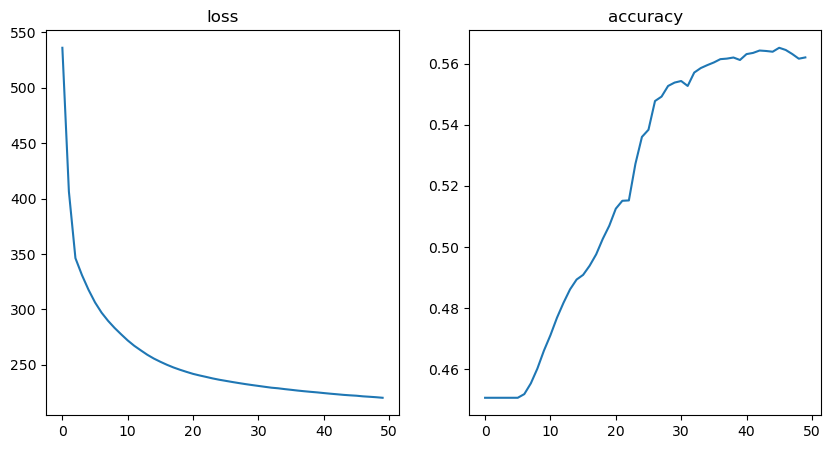

In [74]:
model4 = nn.Sequential(
    nn.LazyLinear(64),
    nn.ReLU(),
    nn.LazyLinear(num_class),
)

model4.to(DEVICE)
summary(model4, input_size = (features.shape))

optim = torch.optim.SGD(model4.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

history4 = evaluate(model4, train_dataloader, test_dataloader, optim, criterion, epochs = 50)

losses = []
acc = []
e = []
for i, d in enumerate(history4):
  l = d['loss']
  a = d['accuracy']
  e.append(i)
  losses.append(l)
  acc.append(a)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(losses, ax = ax1)
ax1.set_title("loss")
sns.lineplot(acc, ax = ax2)
ax2.set_title("accuracy")
plt.show()

torch.save(model4, 'nn2.50epoch.h5')

In [75]:
for hist, name in zip([history, history1, history2, history3, history4], ['Baseline', '2 hidden layers', '3 hidden layers', 'Adam lr = 0.001', 'SGD']):
    print(hist)

[{'loss': 248.41194891929626, 'accuracy': 0.6026800468707749}, {'loss': 156.05585300922394, 'accuracy': 0.668148904846318}, {'loss': 127.3031222820282, 'accuracy': 0.7115043716011177}, {'loss': 111.31400316953659, 'accuracy': 0.7289607307033621}, {'loss': 100.10455757379532, 'accuracy': 0.7499323979208605}, {'loss': 91.87298667430878, 'accuracy': 0.7570831956253944}, {'loss': 86.01019078493118, 'accuracy': 0.7674488477601178}, {'loss': 81.14370054006577, 'accuracy': 0.7754709611513385}, {'loss': 77.10194706916809, 'accuracy': 0.7861971577081392}, {'loss': 73.87442249059677, 'accuracy': 0.7929273202535829}, {'loss': 71.11464434862137, 'accuracy': 0.7951206321545534}, {'loss': 68.74362581968307, 'accuracy': 0.8009193882762972}, {'loss': 66.5088427066803, 'accuracy': 0.8084908211399213}, {'loss': 64.84228676557541, 'accuracy': 0.8120361746236817}, {'loss': 62.990614235401154, 'accuracy': 0.811645584833098}, {'loss': 61.31744432449341, 'accuracy': 0.8153411651593907}, {'loss': 60.279434978

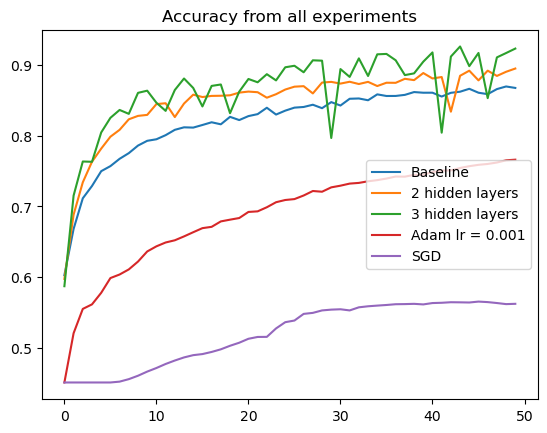

In [76]:
for hist, name in zip([history, history1, history2, history3, history4], ['Baseline', '2 hidden layers', '3 hidden layers', 'Adam lr = 0.001', 'SGD']):
    acc = []
    for d in hist:
        acc.append(d['accuracy'])
    e = list(range(len(acc))) 

    sns.lineplot(acc, label = name)

plt.title('Accuracy from all experiments')
plt.show()
